In [1]:
import sys
sys.path.append("../../BayesFlow")
sys.path.append("../")

import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import pickle

import keras

In [2]:
import bayesflow as bf
from dmc import DMC, dmc_helpers

with torch.enable_grad():
in contexts where you need gradients (e.g. custom training loops).


In [3]:
simulator = DMC(
    prior_means=np.array([16., 111., 0.5, 322., 75.]), 
    prior_sds=np.array([10., 47., 0.13, 40., 23.]),
    tmax=1500
)


In [4]:
approximator = keras.saving.load_model("../checkpoints/optuna_run1.keras")

/home/space/anaconda3/envs/bf/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


In [5]:
import pandas as pd

narrow_data = pd.read_csv('../data/model_data/experiment_data_narrow.csv')
wide_data = pd.read_csv('../data/model_data/experiment_data_wide.csv')

empirical_data = pd.concat([narrow_data, wide_data])

In [6]:
samples_narrow=dmc_helpers.fit_empirical_data(narrow_data, approximator)

samples_narrow["spacing"]="narrow"

samples_wide=dmc_helpers.fit_empirical_data(wide_data, approximator)

samples_wide["spacing"]="wide"


data_complete=pd.concat((samples_wide, samples_narrow))

In [7]:
parts=data_complete["participant"].unique()

data_complete

A         tau      mu_c          t0          b  participant  \
0     5.173779   85.891556  0.528632  282.433716  70.936241         1108   
1     9.519680   98.080460  0.577731  282.772247  77.645363         1108   
2     5.217581   82.160477  0.594156  284.805908  73.991554         1108   
3     6.547664   70.002792  0.532864  284.998291  66.133469         1108   
4     5.491337   90.175476  0.580948  282.005493  75.784897         1108   
..         ...         ...       ...         ...        ...          ...   
995  13.732784  131.096497  0.659707  309.453003  94.847916       337788   
996  17.030991  132.504944  0.621822  312.722778  81.495766       337788   
997  19.504423  149.265228  0.644694  308.618866  90.507950       337788   
998  15.324767  117.062706  0.638829  310.694916  87.189621       337788   
999  19.704891  151.557007  0.688446  316.182068  89.640694       337788   

     sampling_time spacing  
0         0.021111    wide  
1         0.021111    wide  
2         0.021111    wide  
3         0.021111    wide  
4         0.021111    wide  
..             ...     ...  
995       0.018597  narrow  
996       0.018597  narrow  
997       0.018597  narrow  
998       0.018597  narrow  
999       0.018597  narrow  

[134000 rows x 8 columns]

/tmp/ipykernel_16883/3701706333.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,5, figsize=(15,3))


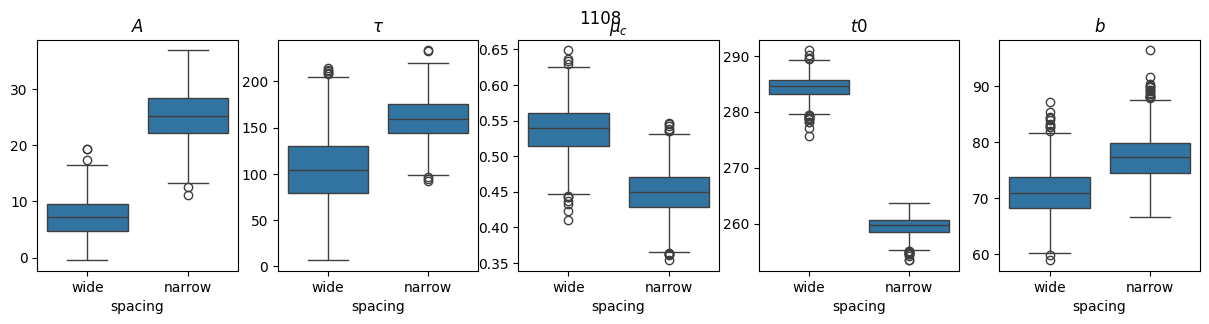

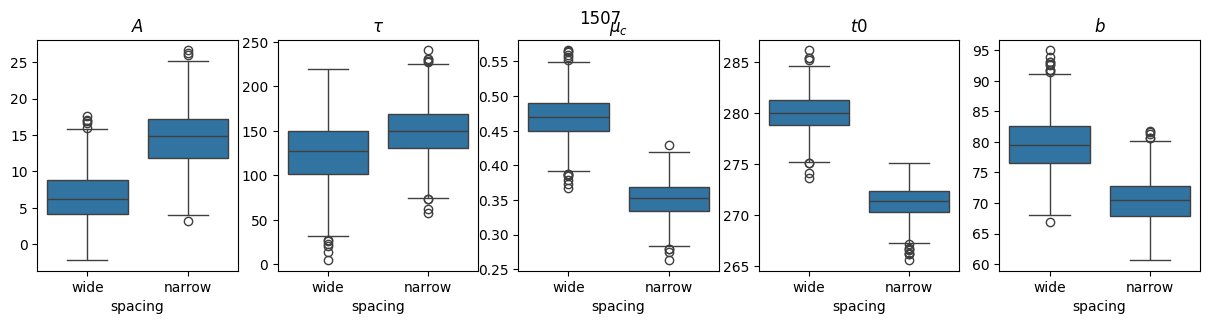

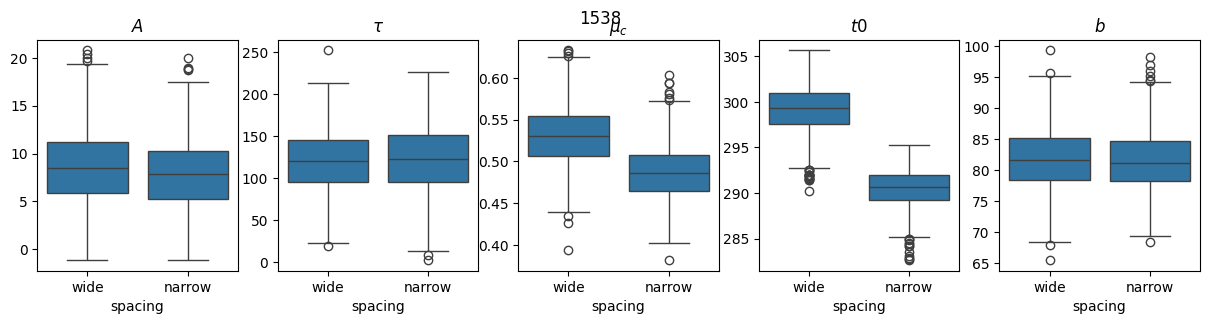

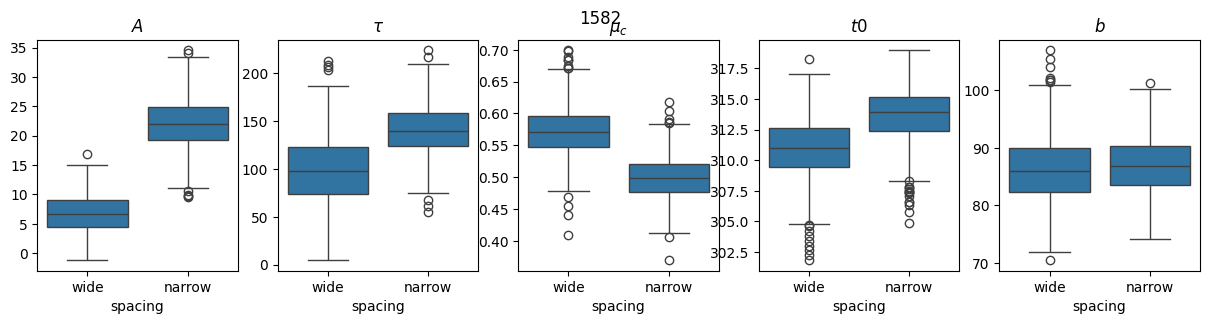

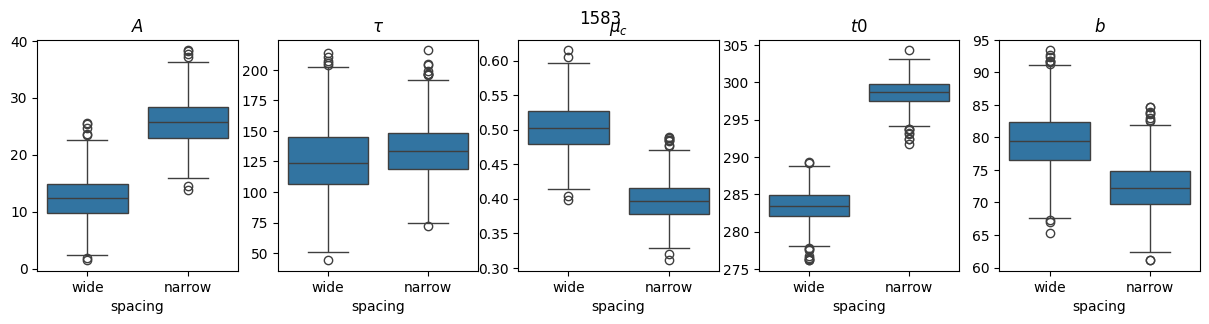

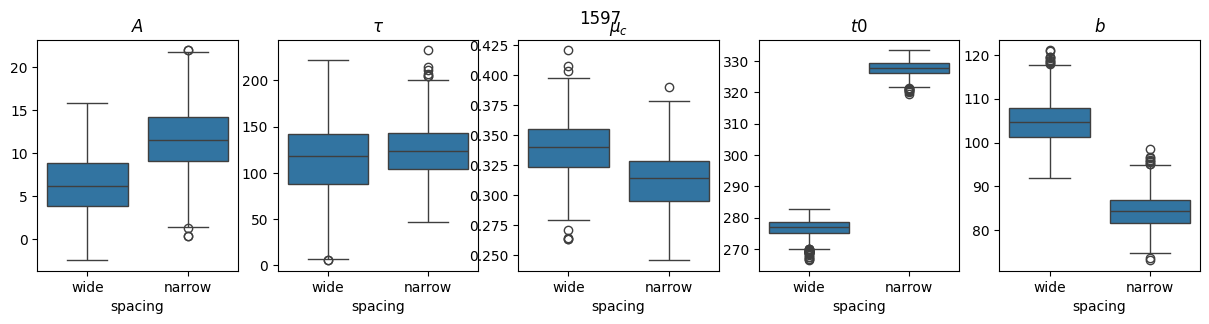

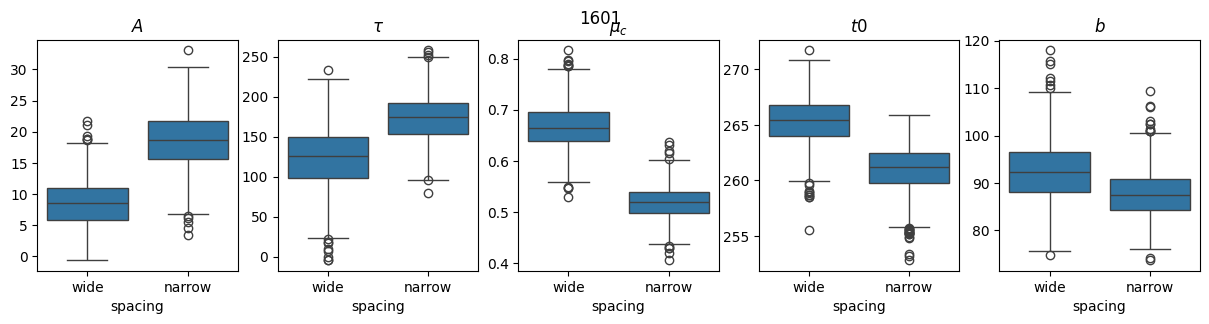

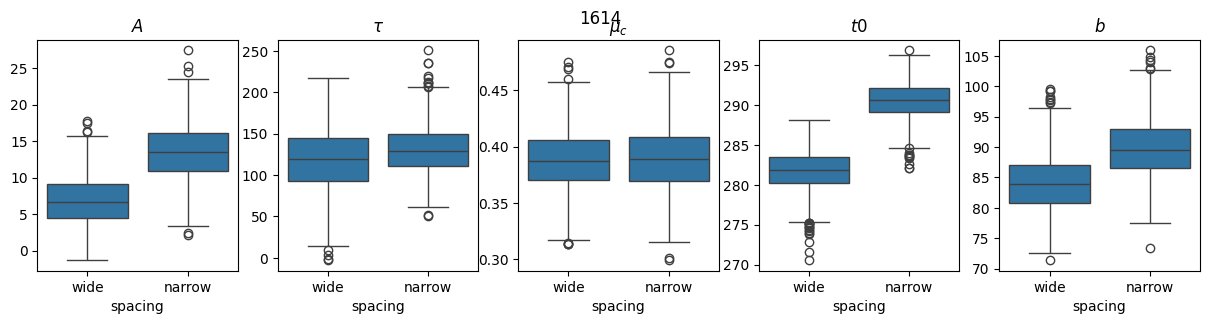

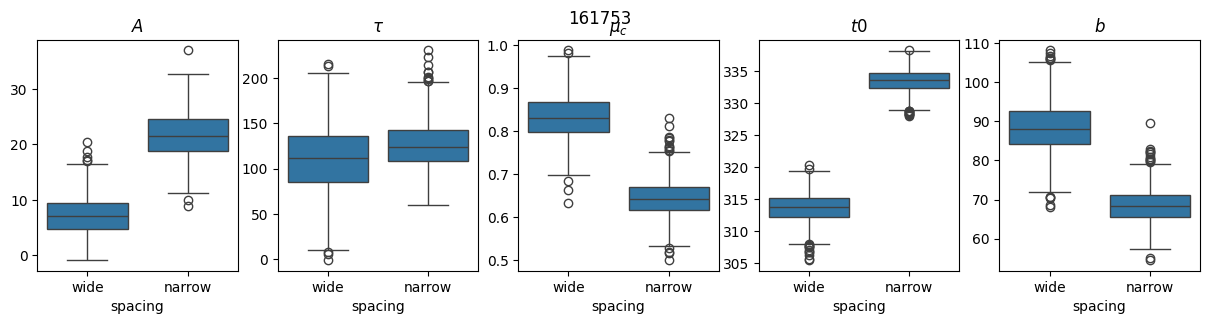

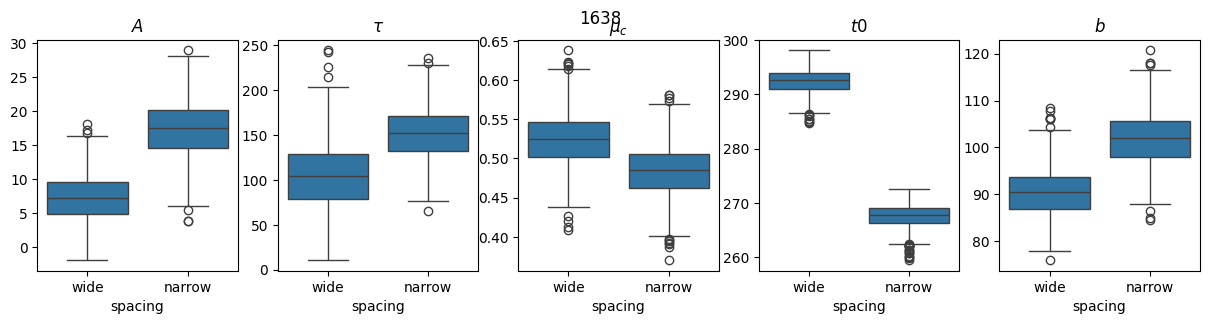

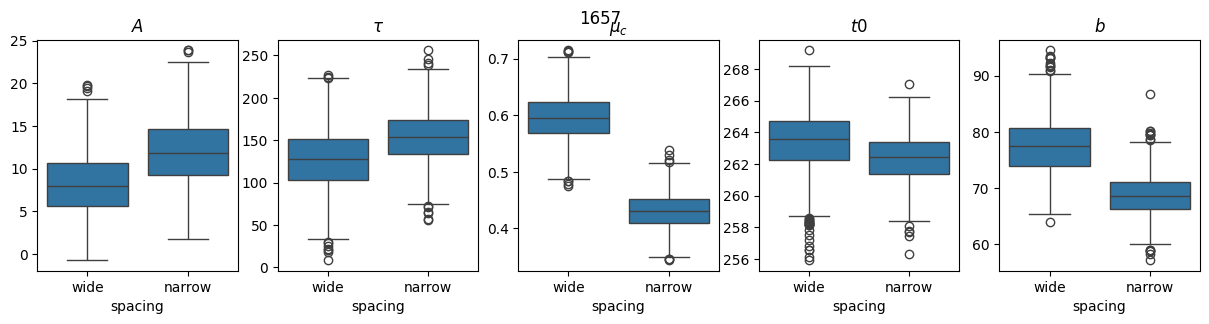

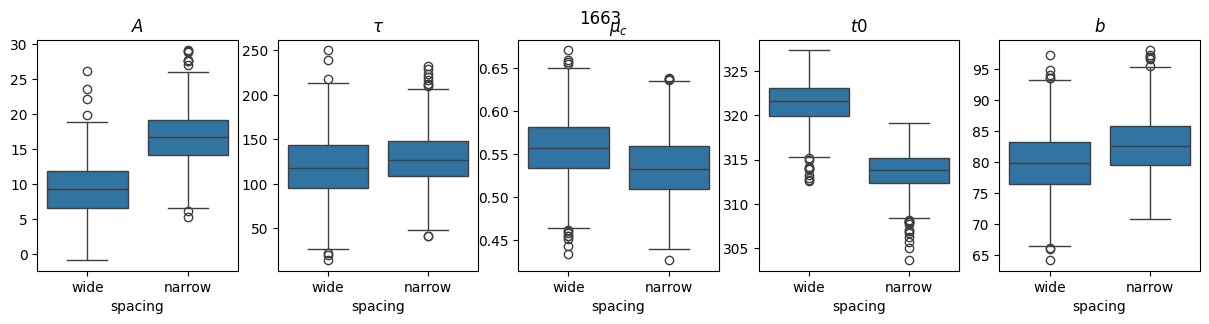

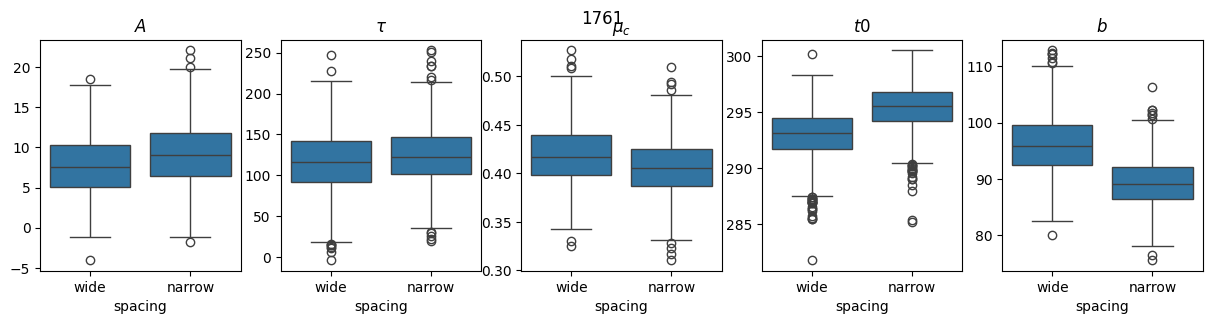

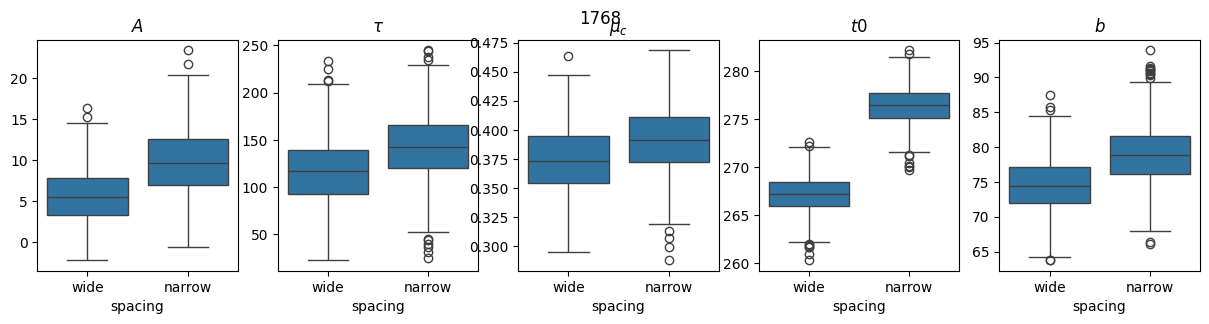

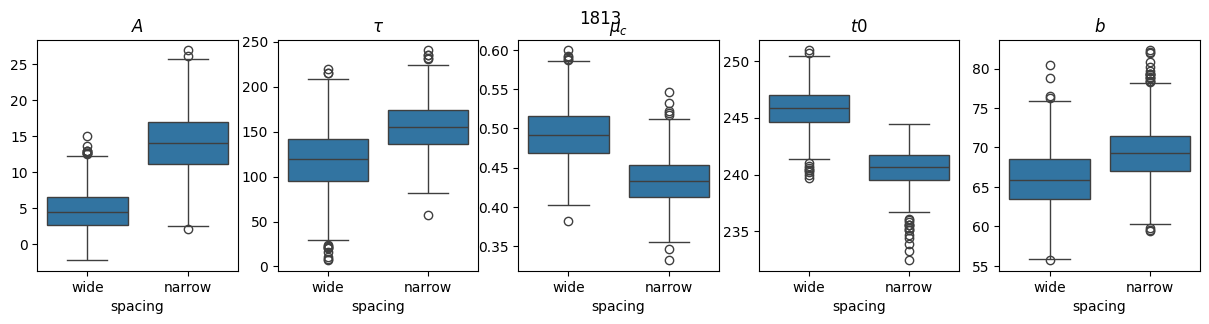

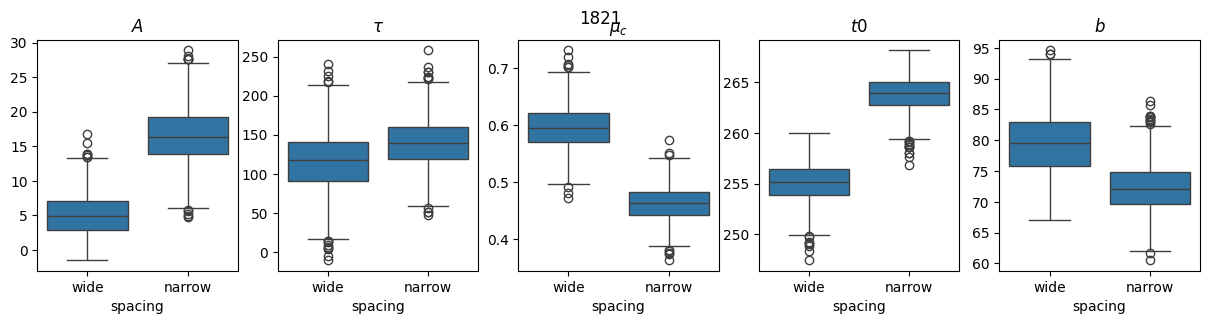

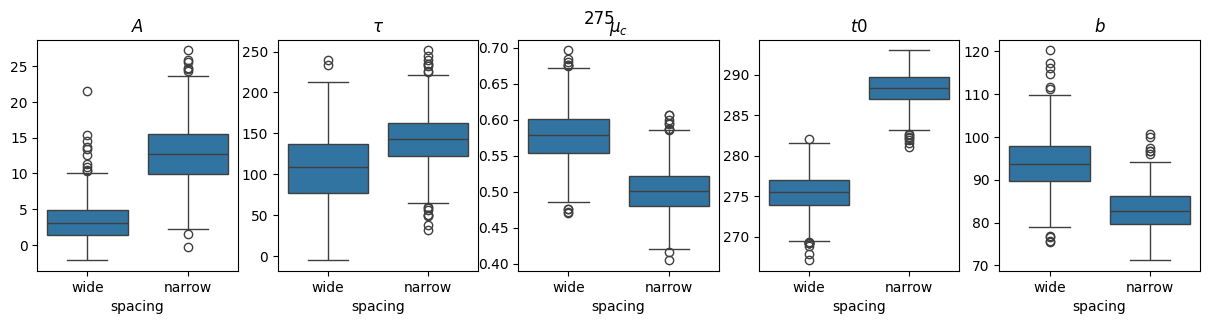

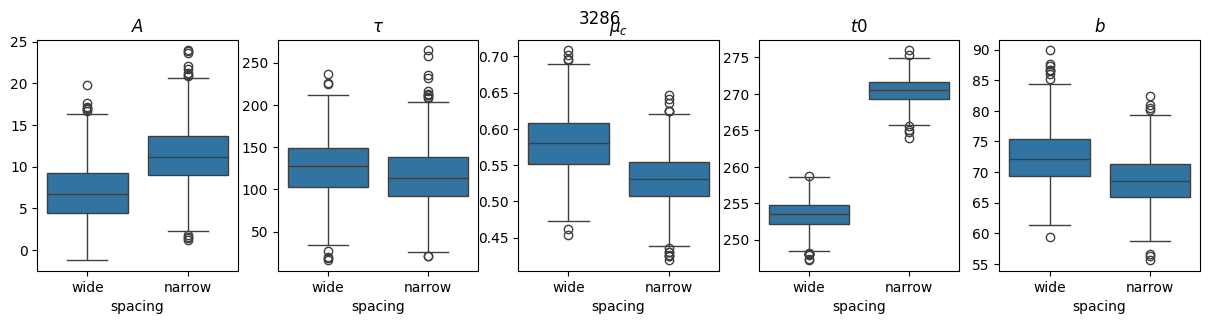

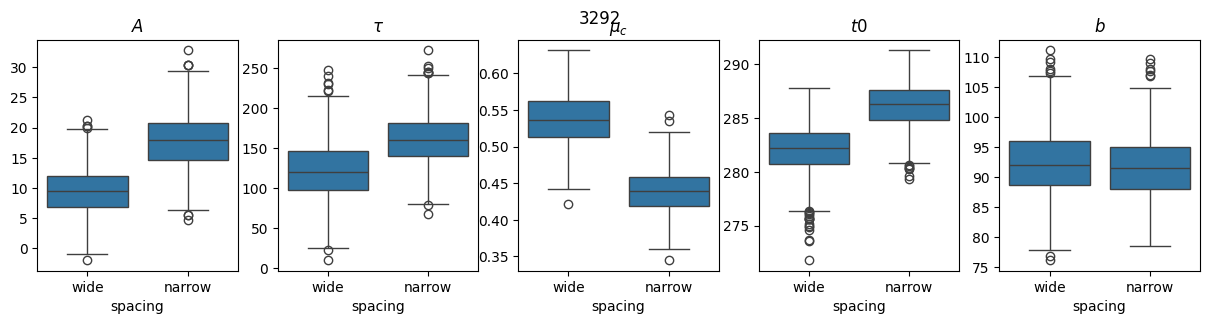

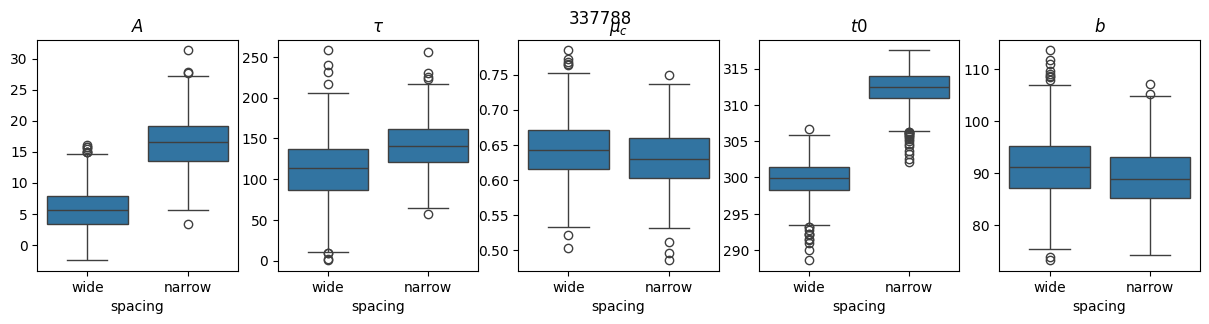

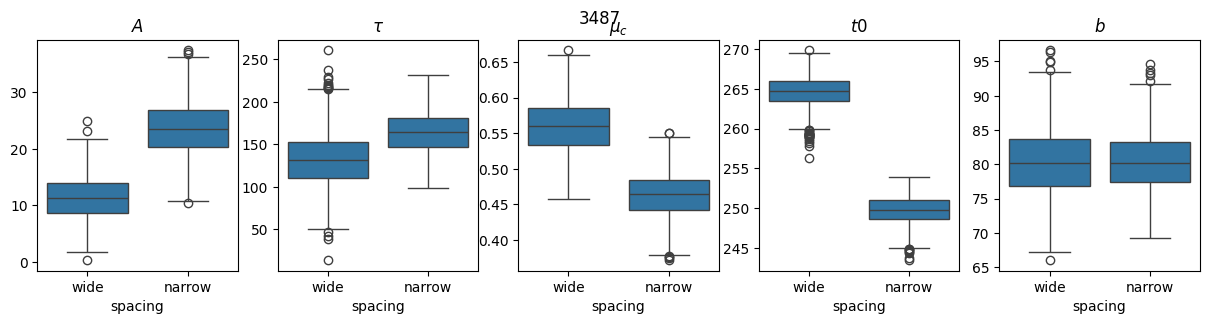

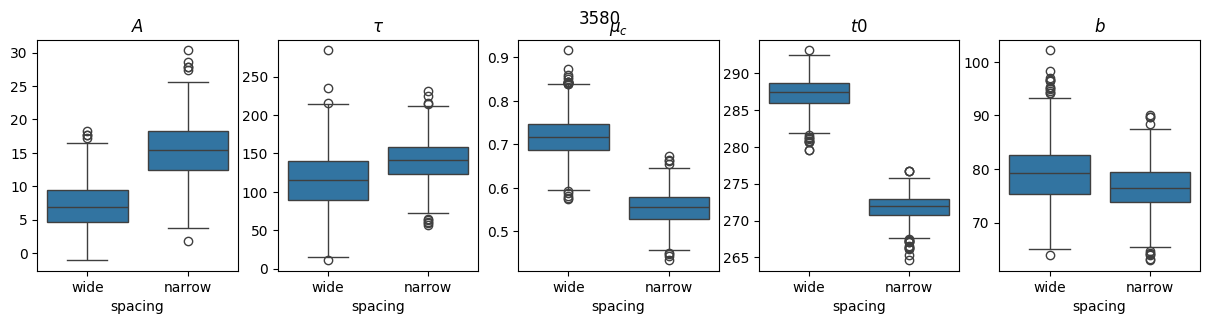

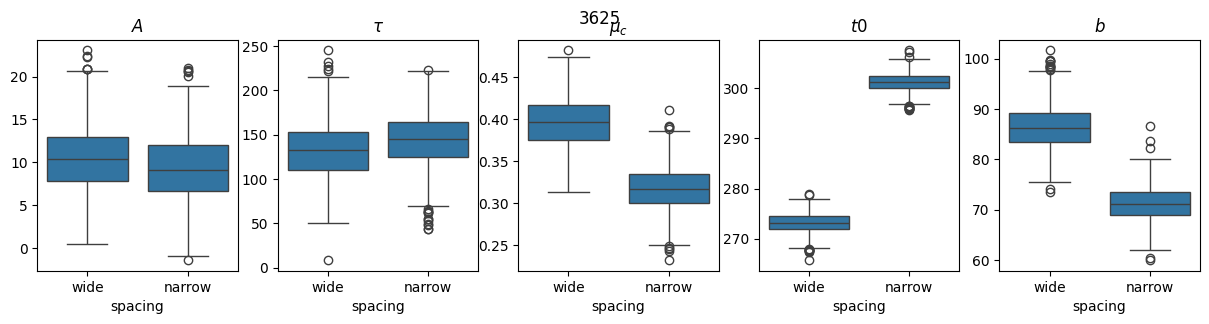

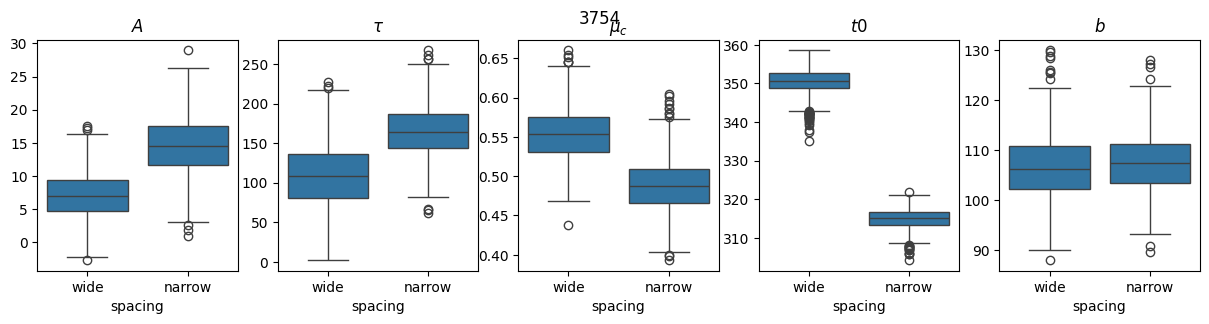

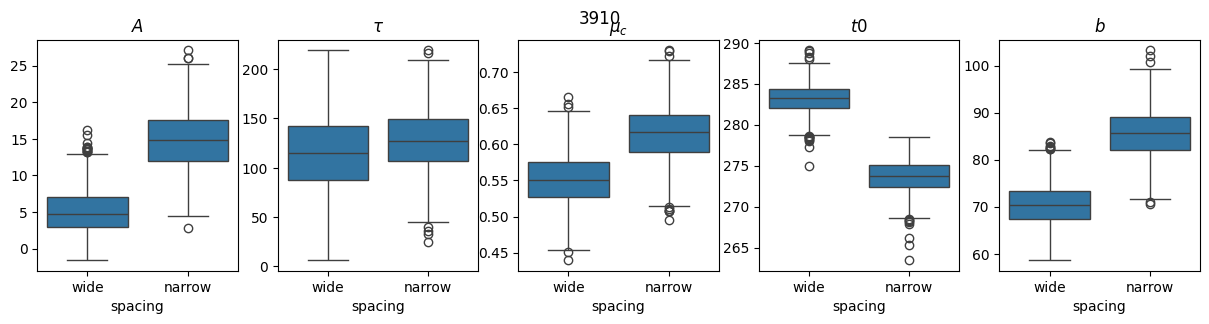

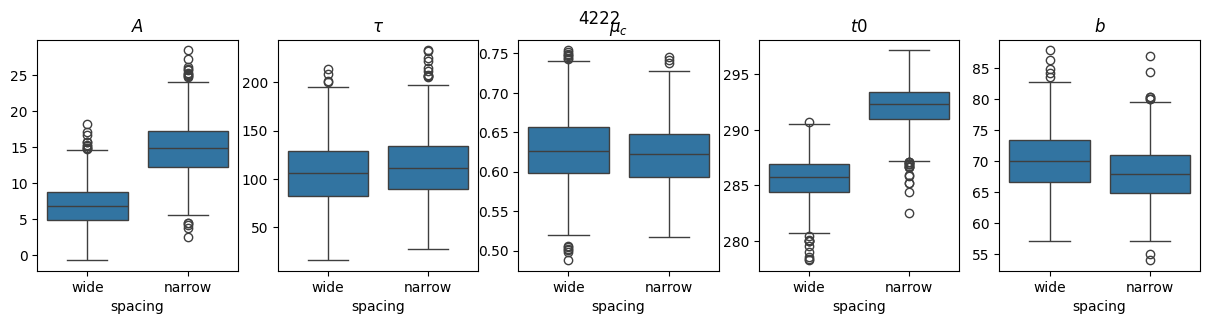

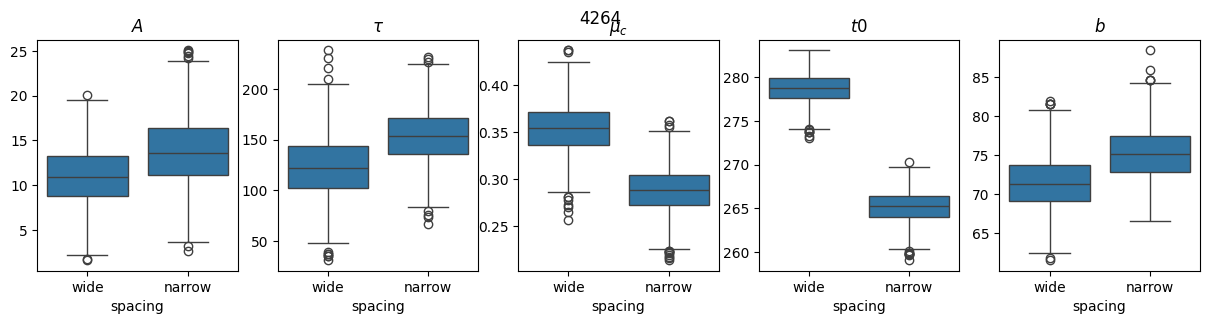

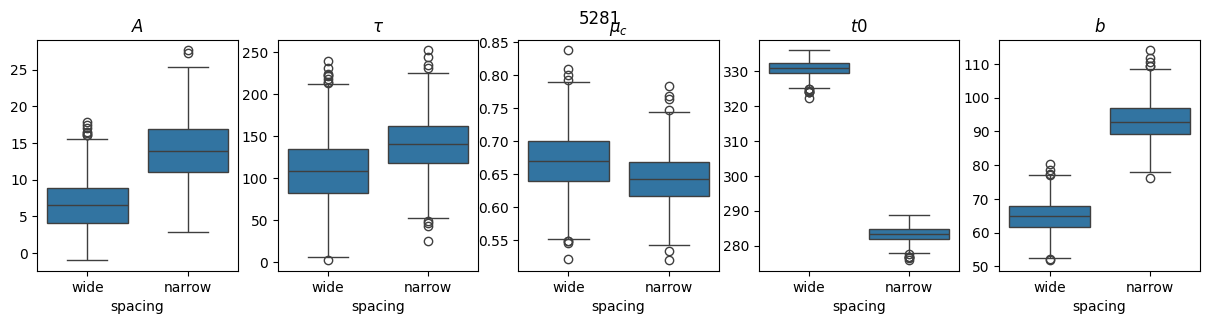

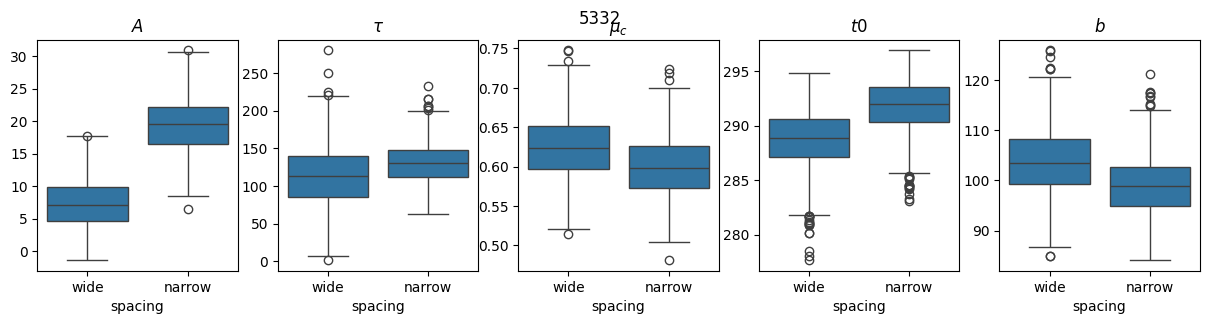

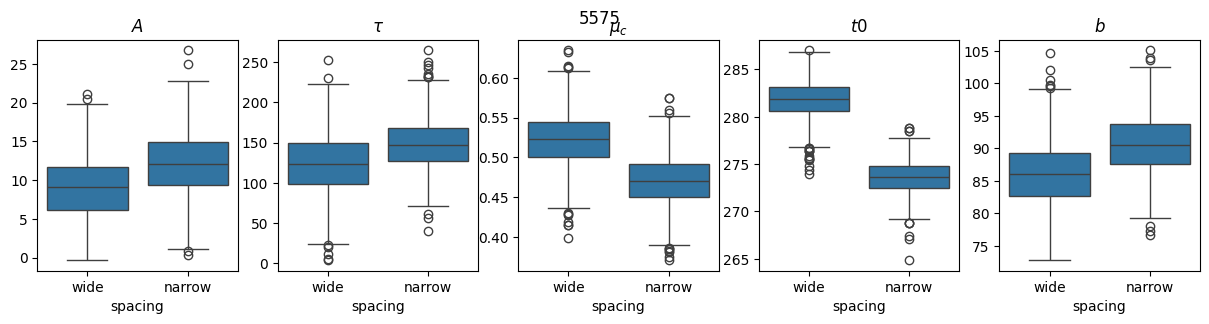

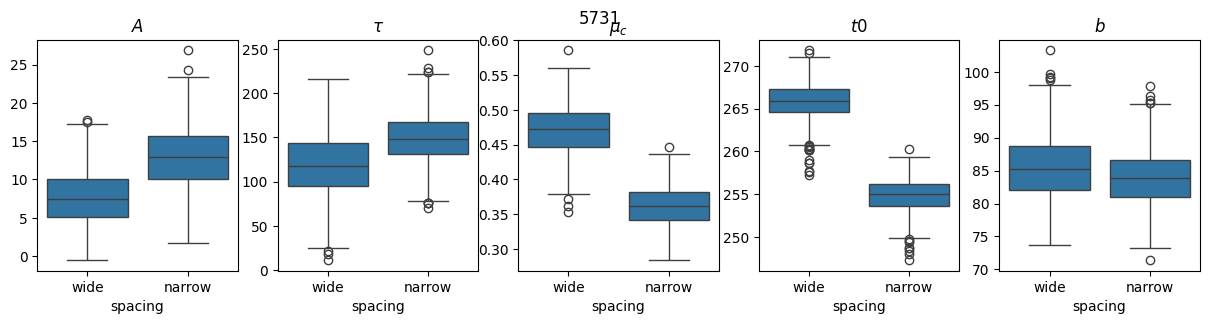

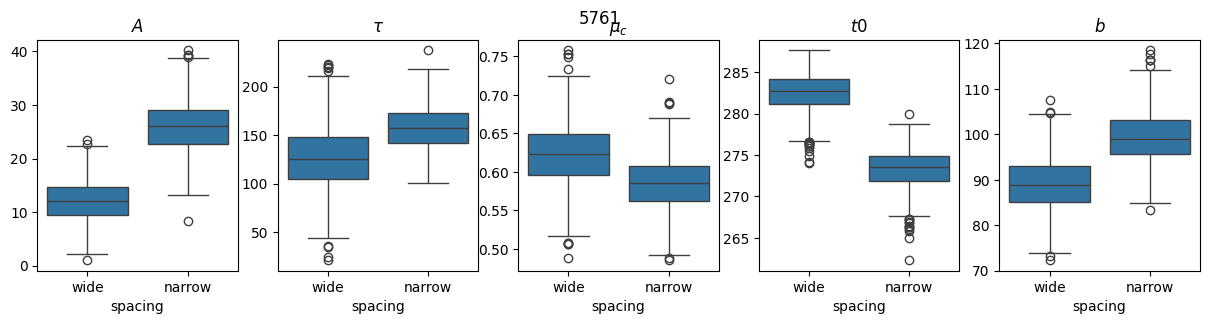

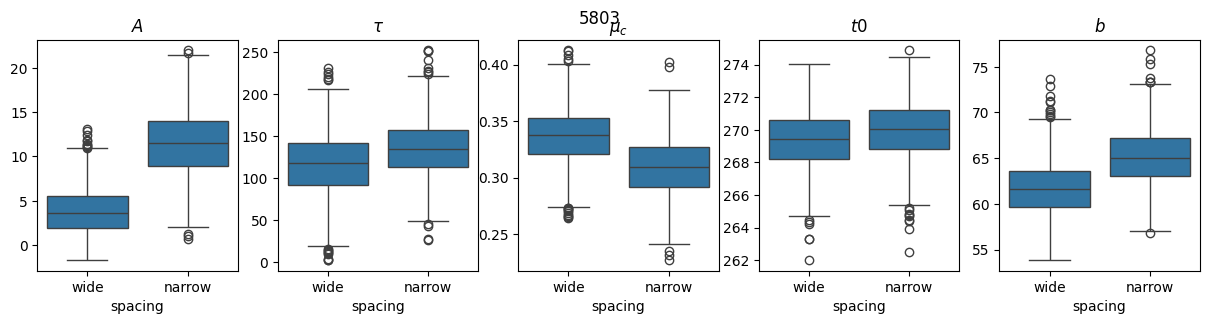

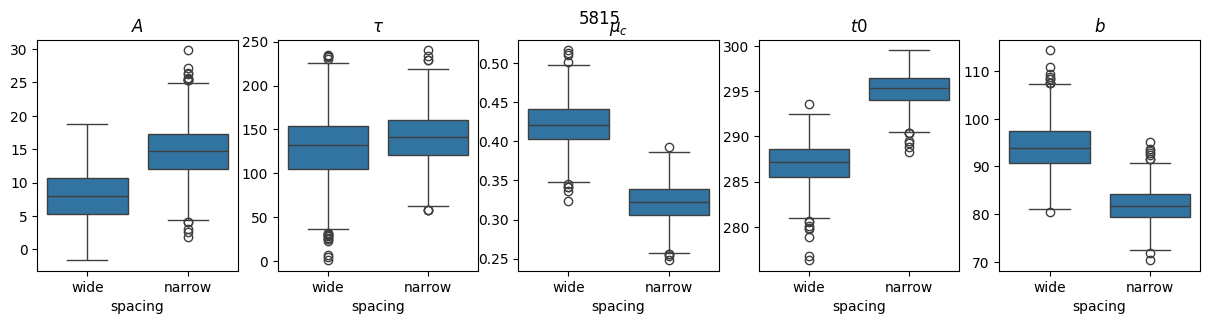

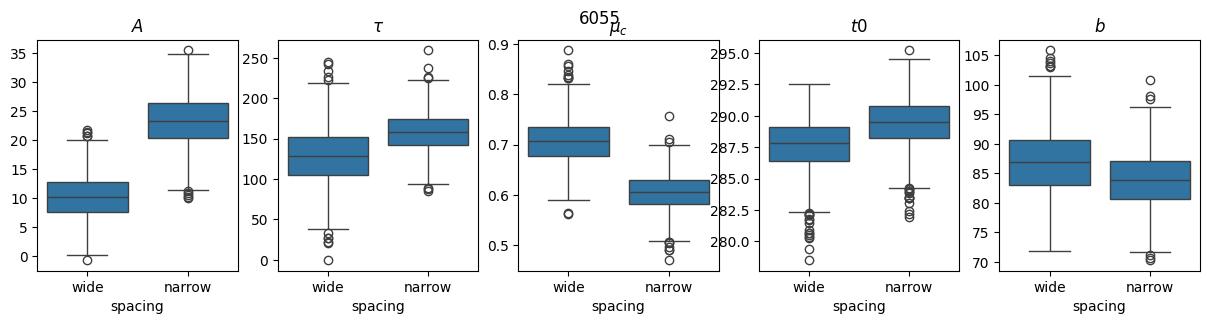

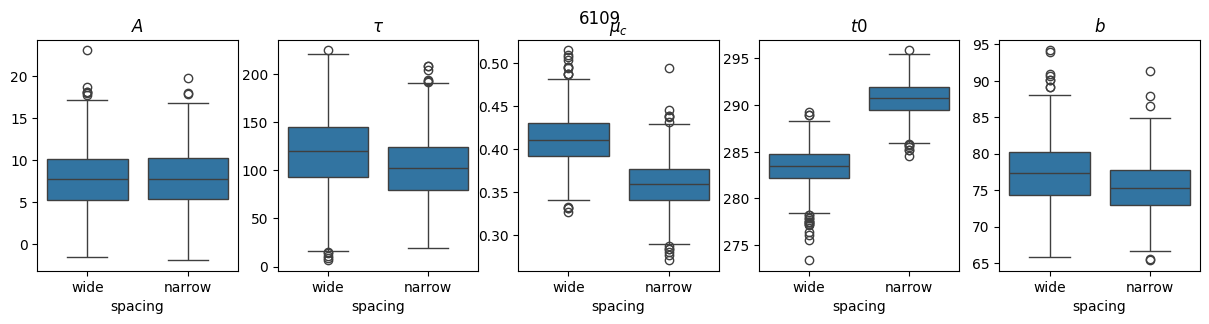

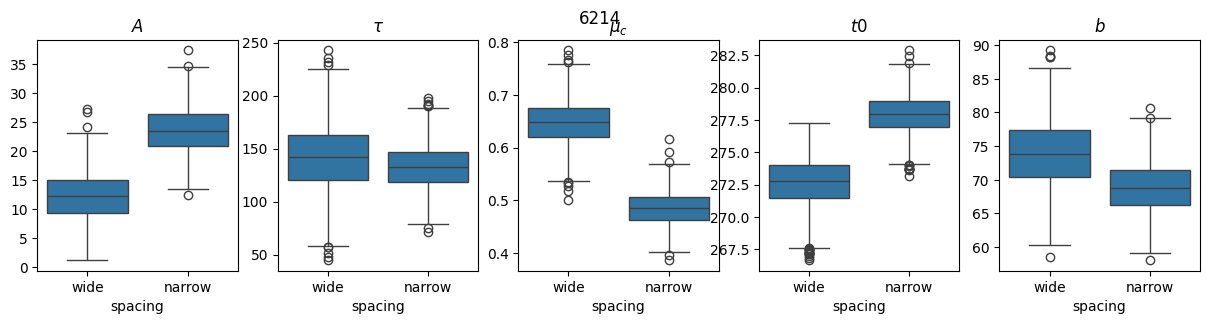

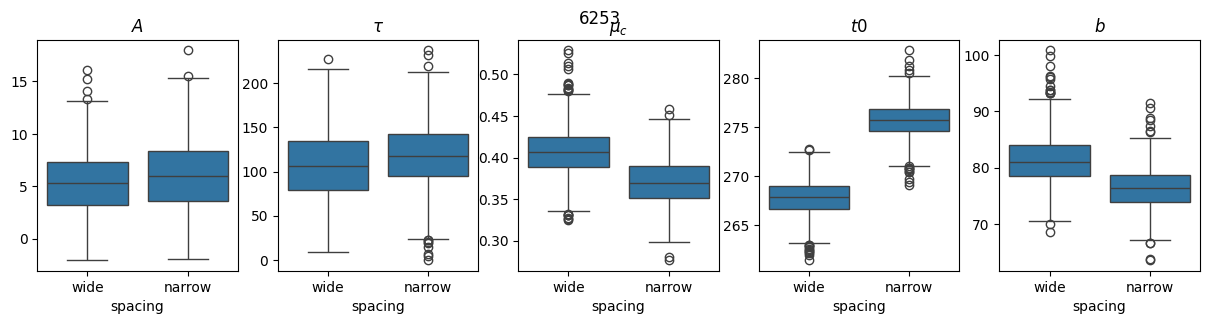

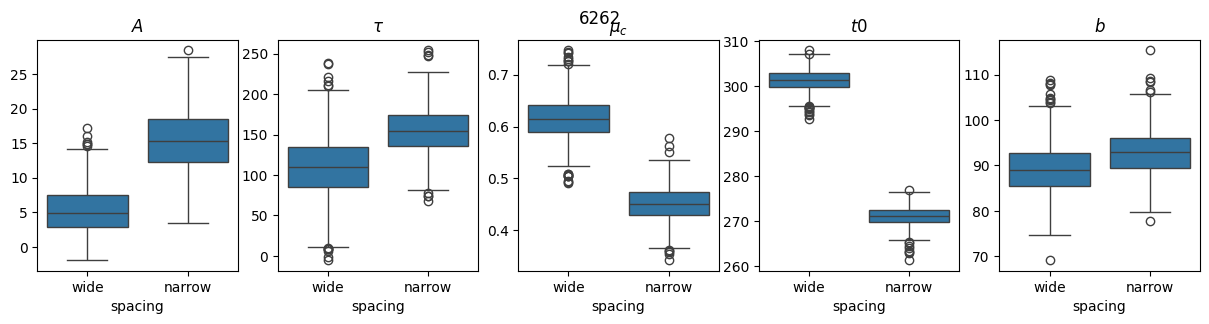

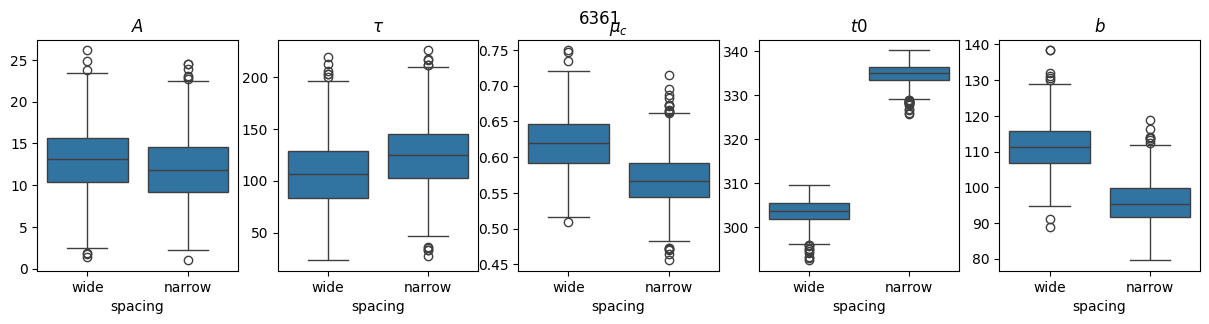

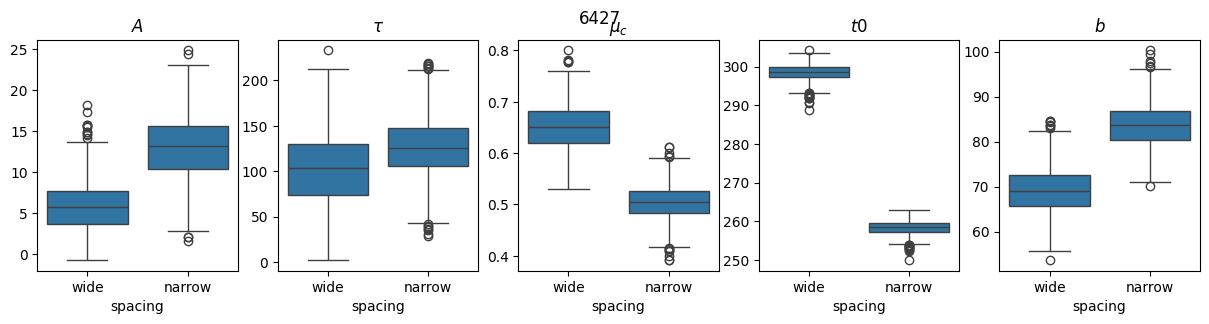

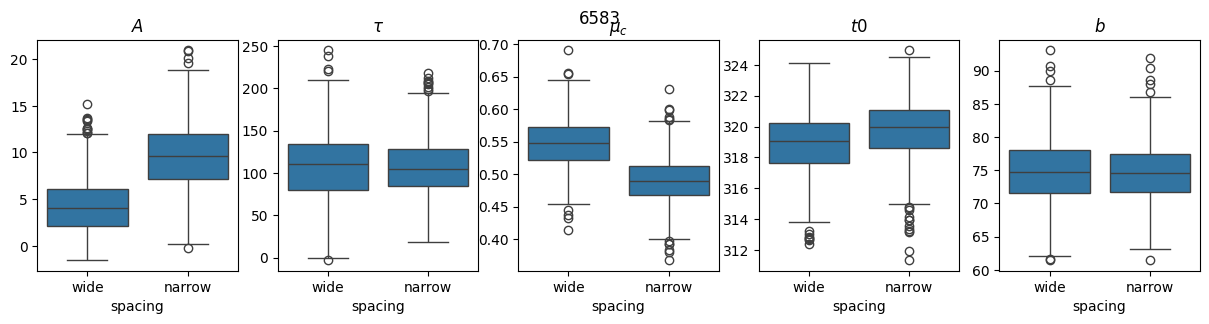

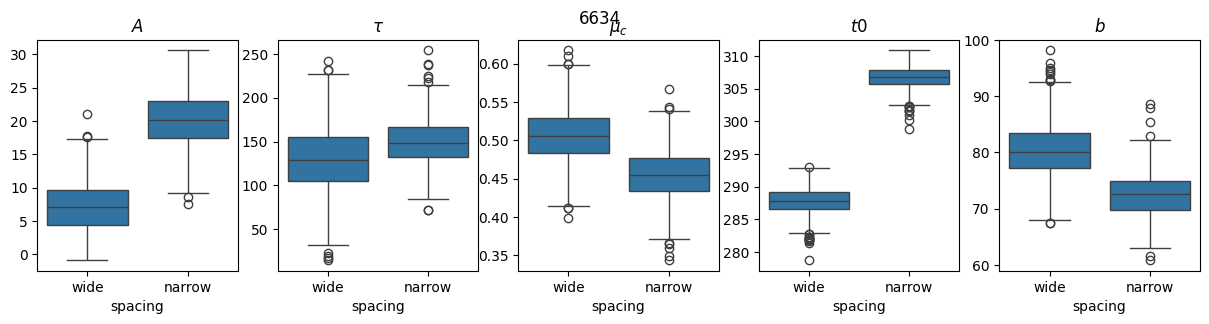

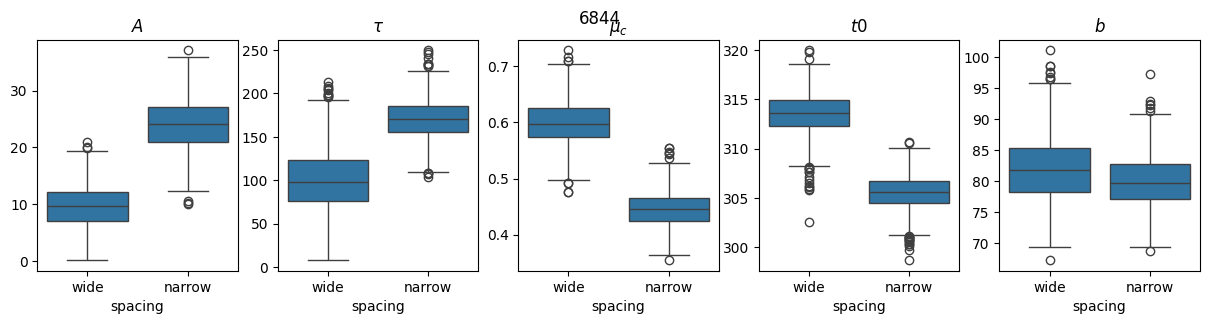

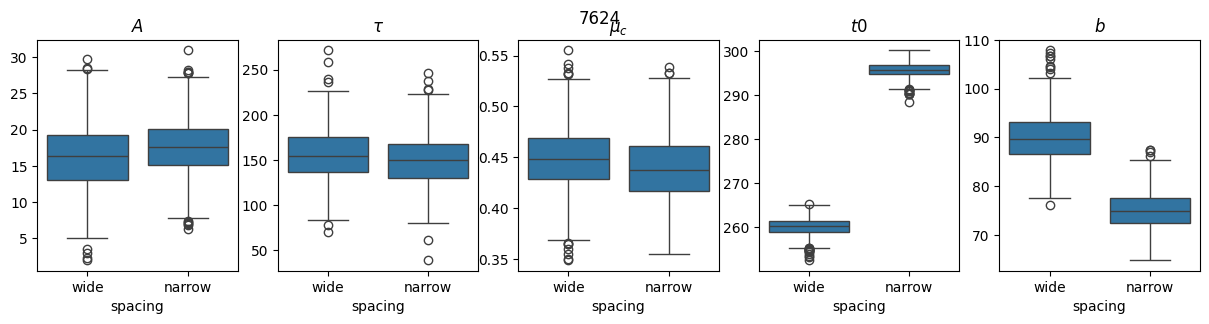

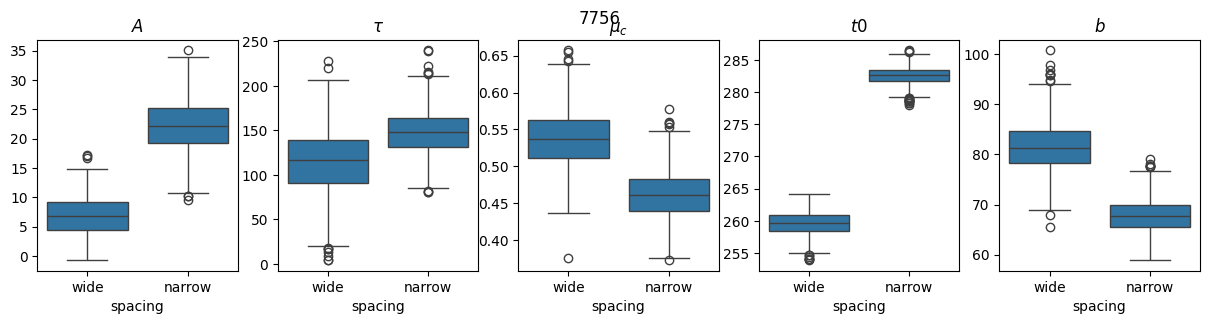

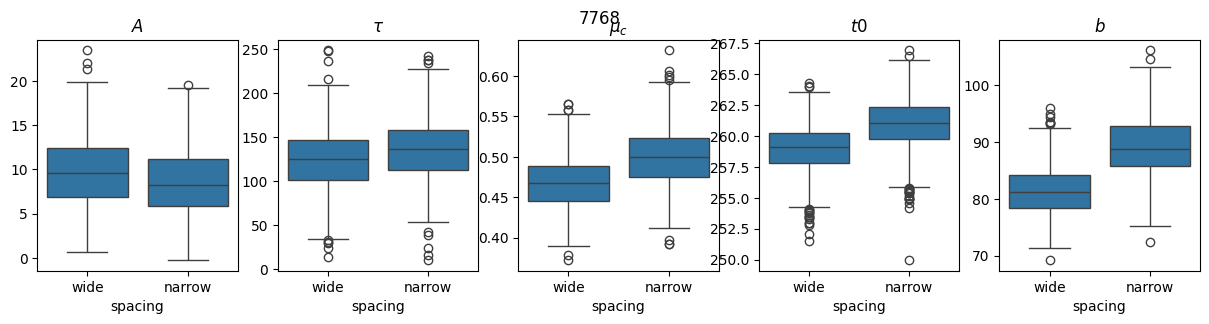

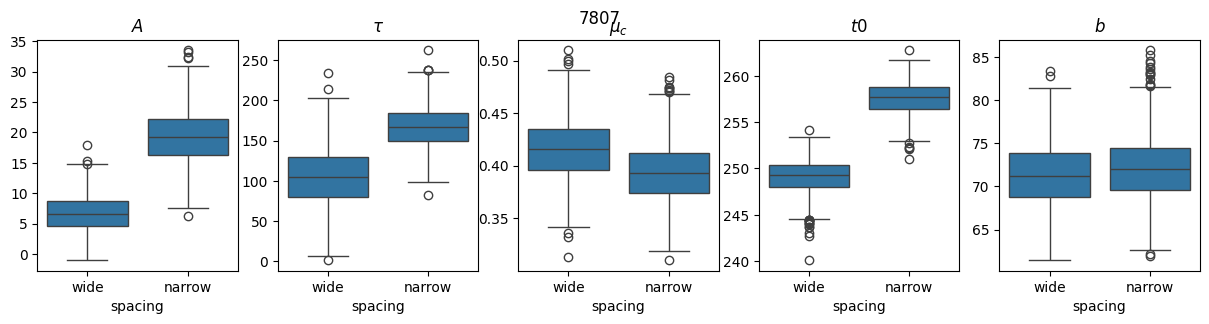

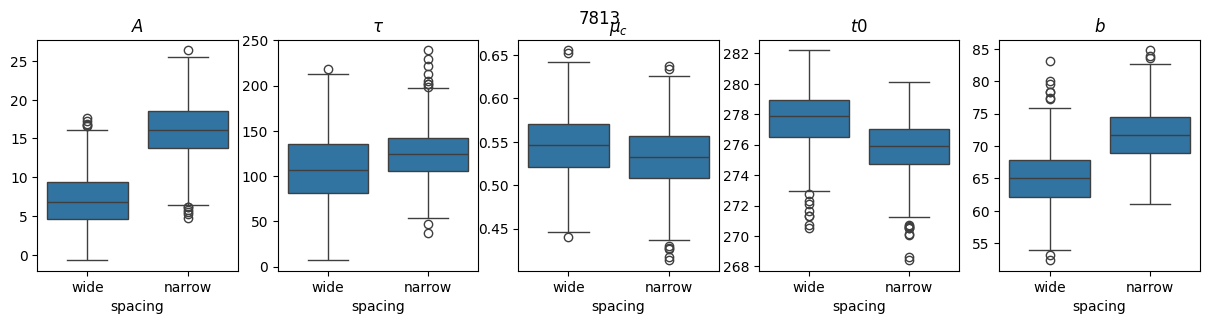

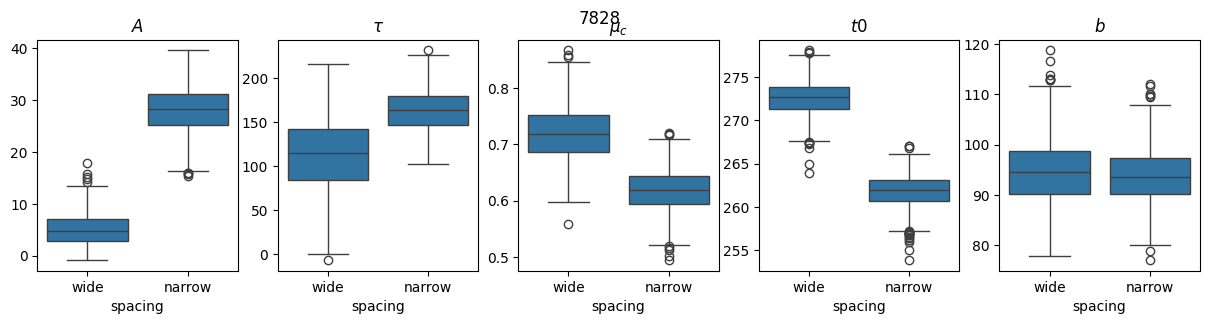

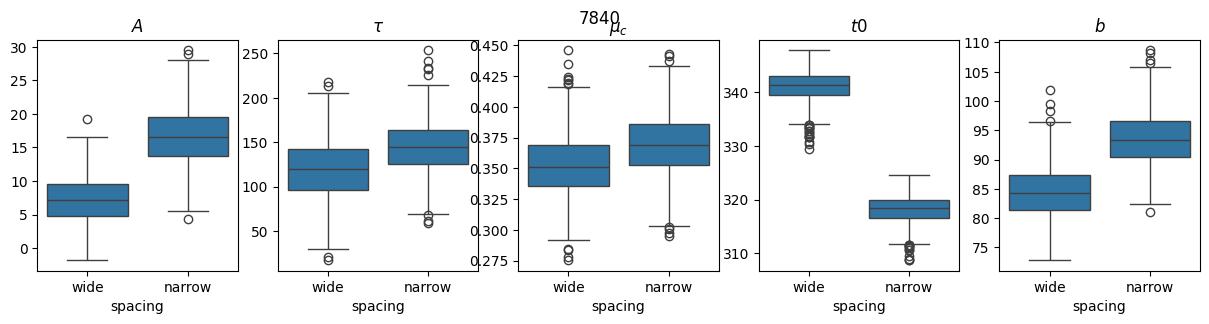

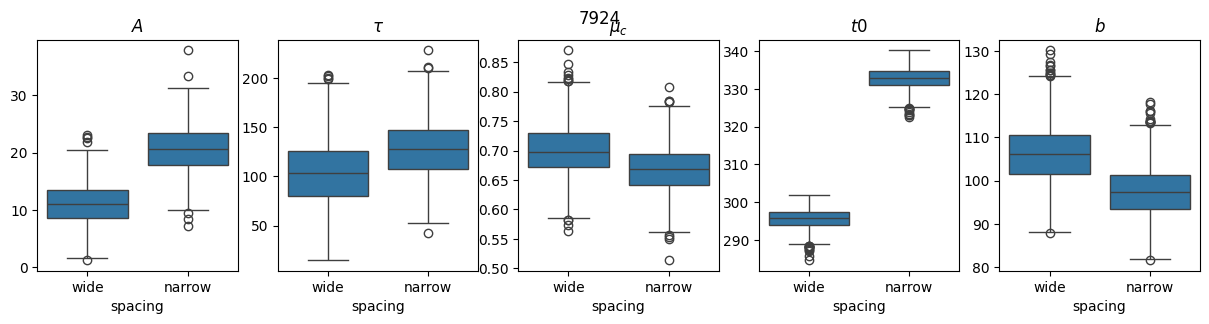

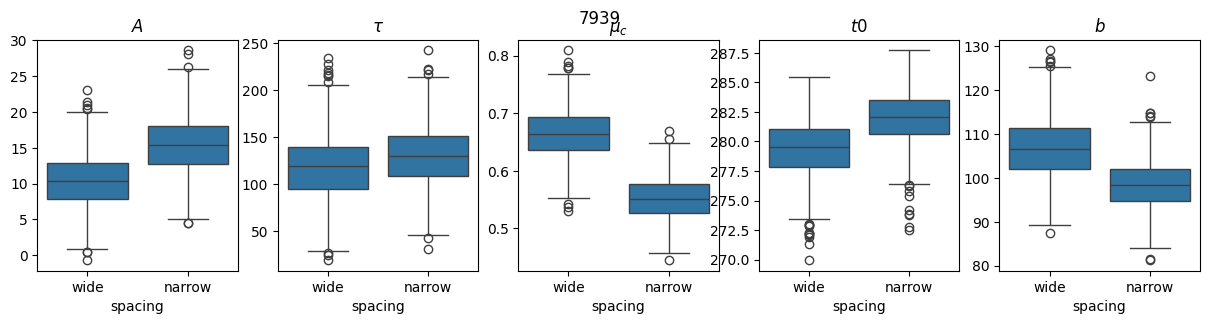

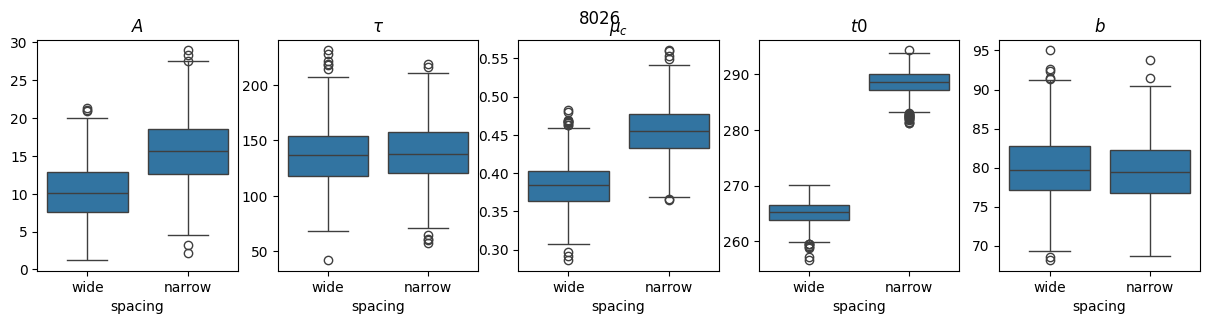

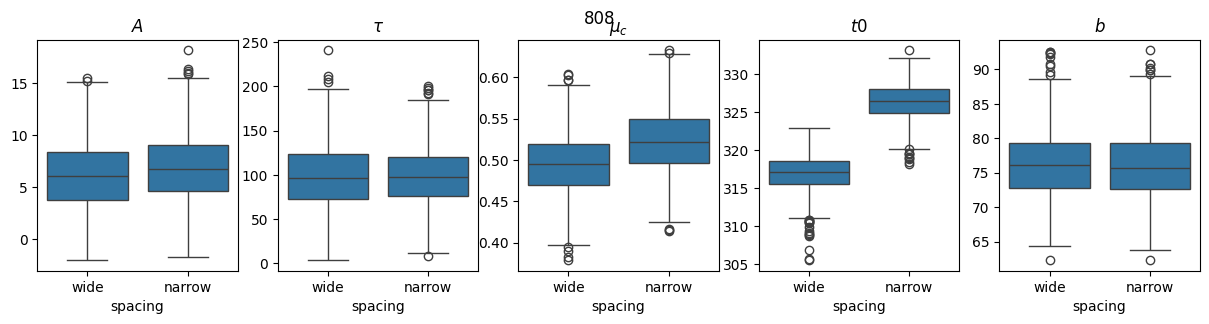

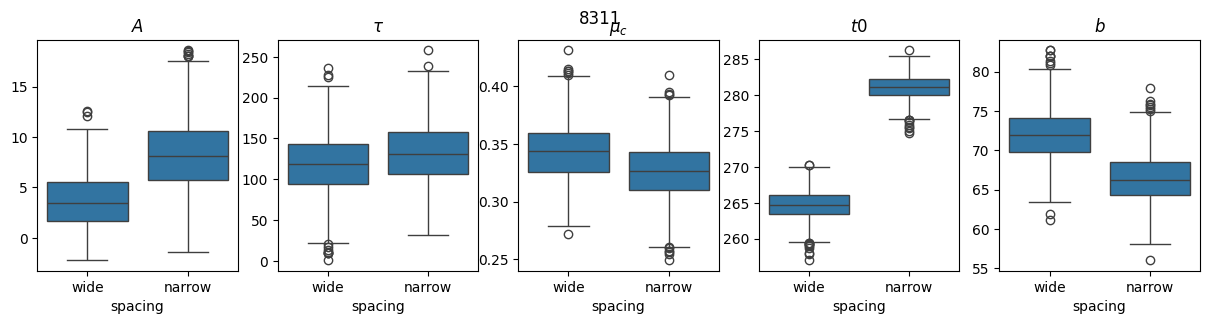

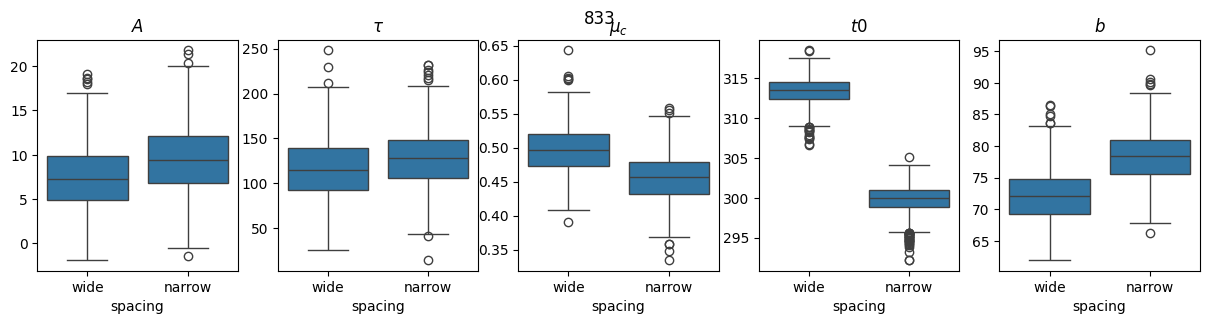

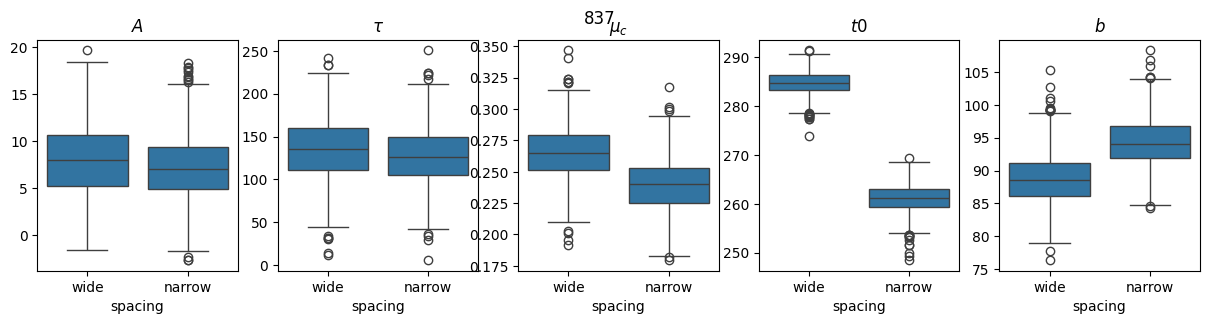

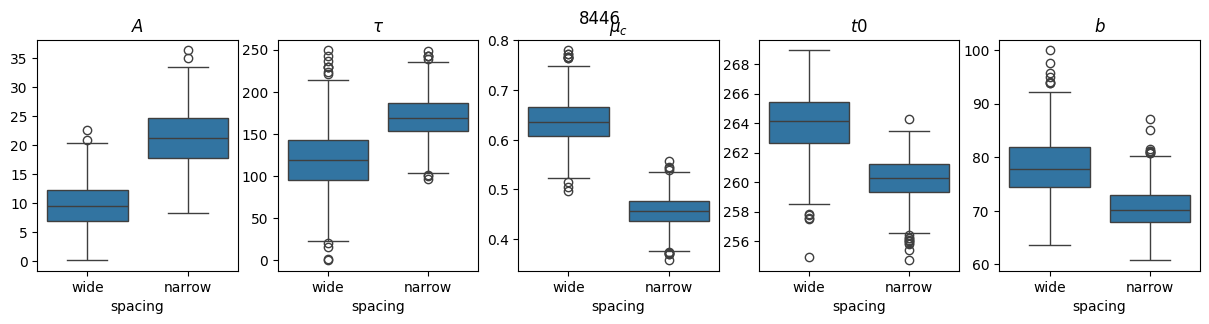

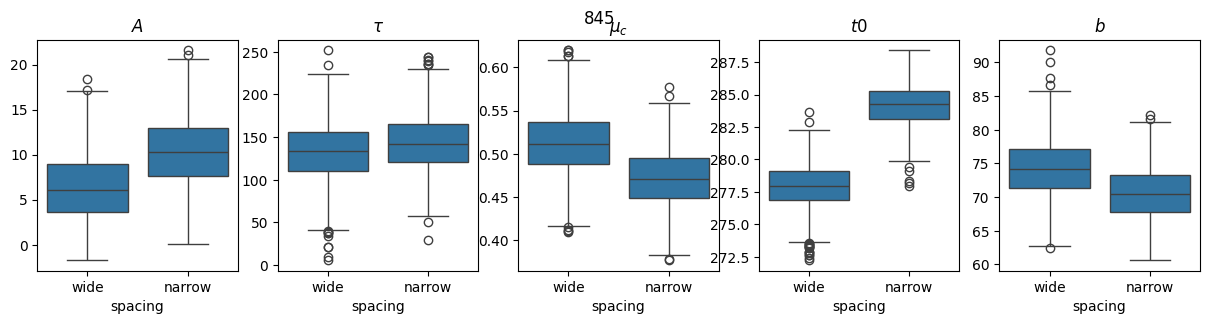

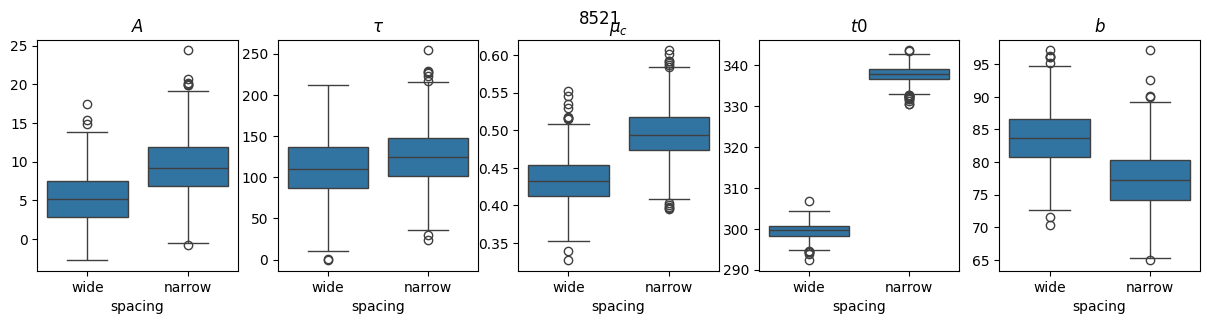

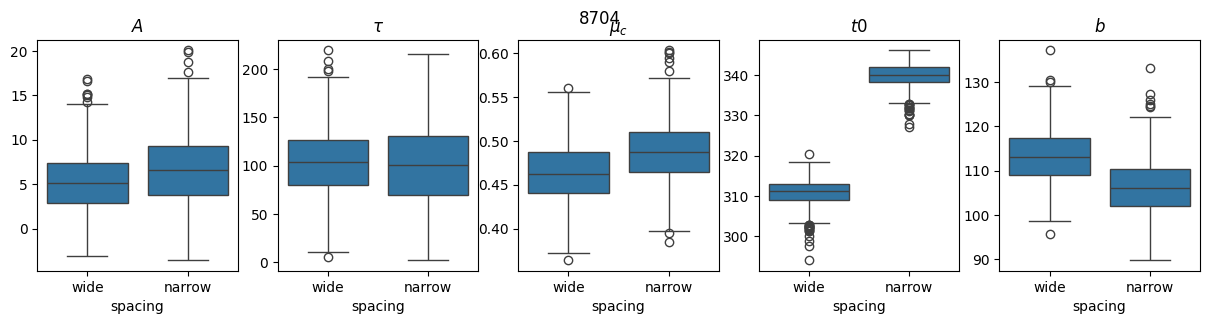

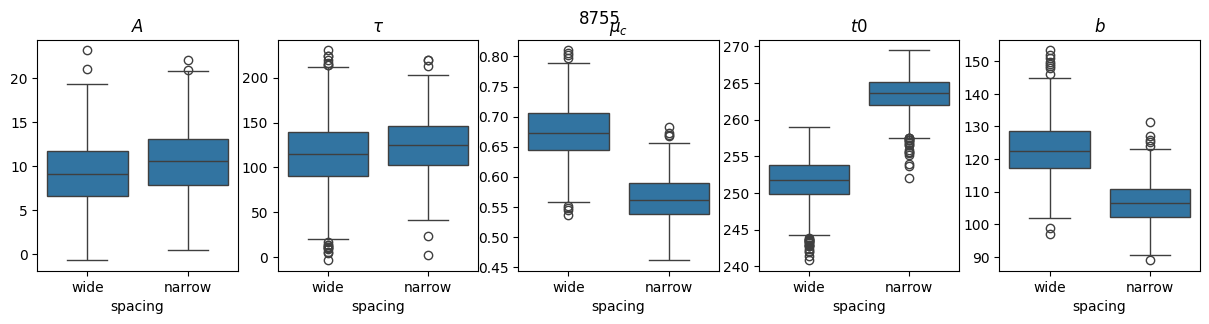

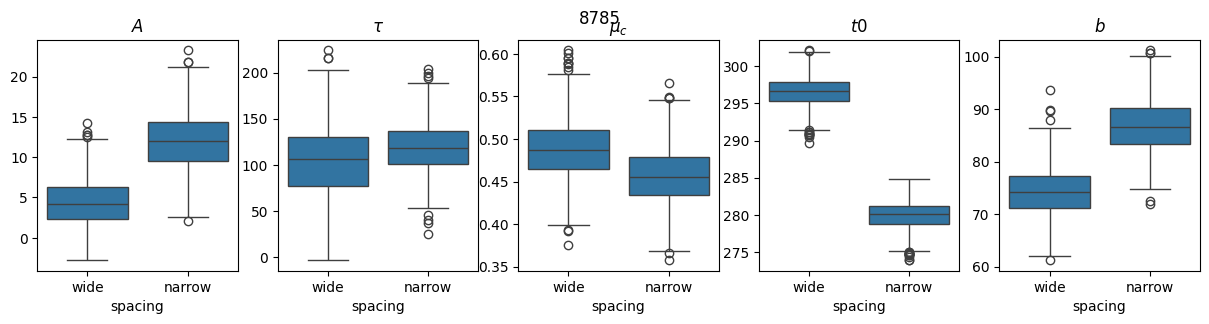

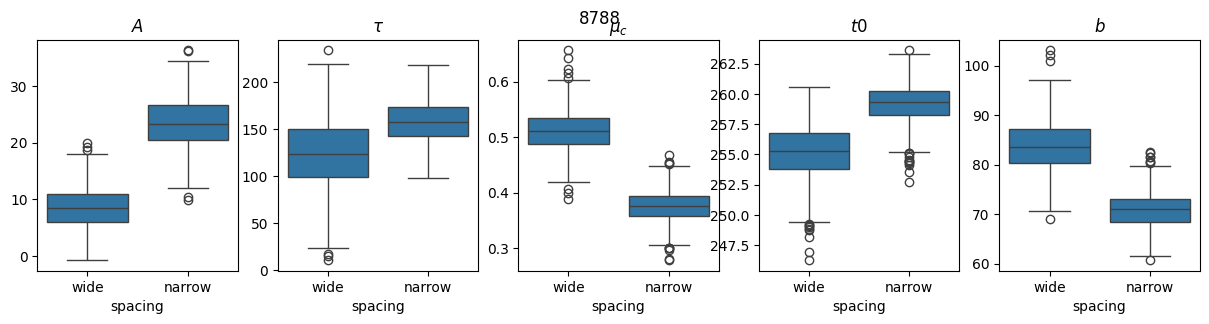

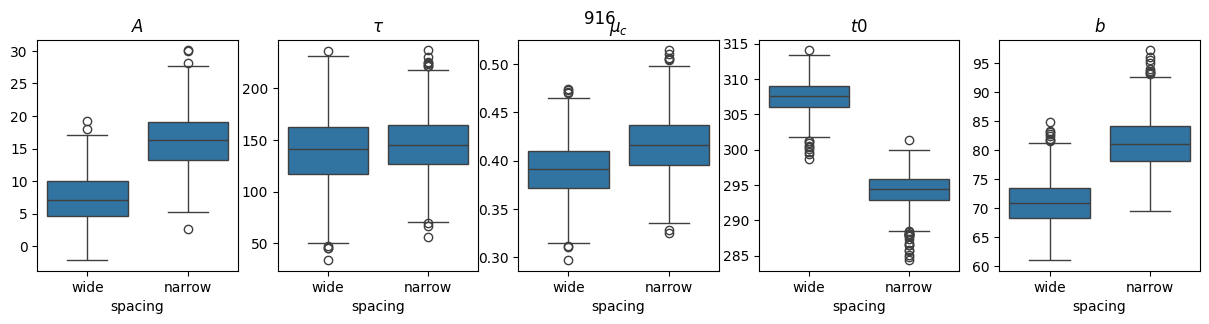

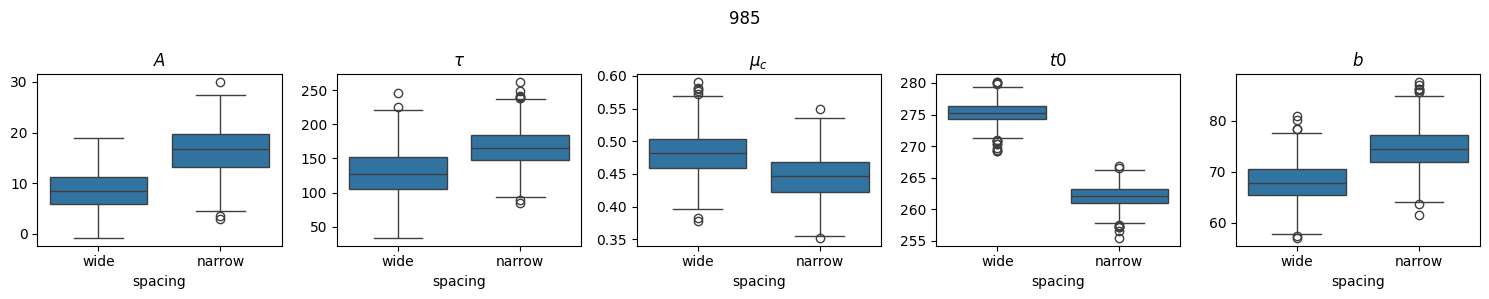

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

param_names = ["A", "tau", "mu_c", "t0", "b"]

for i, part in enumerate(parts):
    
    fig, axes = plt.subplots(1,5, figsize=(15,3))

    for p, ax in zip(param_names, axes):
        
        part_data = data_complete[data_complete["participant"]==part]
        
        sns.boxplot(part_data, ax=ax, x="spacing", y=p)
        ax.set_ylabel("")

        suff = "$\\" if p in ["tau", "mu_c"] else "$"

        label = suff + p + "$"

        ax.set_title(label)
        
        # ax.set_xlabel(p)
    
    fig.suptitle(str(part))
        
fig.tight_layout()

## Posterior Predictive Check

In [41]:
data_complete

A         tau      mu_c          t0          b  participant  \
0     9.030750   89.165985  0.570006  283.235596  78.070099         1108   
1     5.366776  129.963043  0.554997  281.862213  77.193336         1108   
2     3.268147  112.485741  0.525871  283.656586  71.665512         1108   
3     9.813831   72.987625  0.518446  283.884491  72.024734         1108   
4     8.614408  144.185455  0.497316  281.257141  71.263542         1108   
..         ...         ...       ...         ...        ...          ...   
995  14.667790  156.453033  0.633320  313.005188  83.181229       337788   
996  22.721596  156.989716  0.694127  314.588959  98.284401       337788   
997  16.125271  125.240410  0.650542  311.045776  93.535690       337788   
998  16.479042  104.828812  0.659357  313.136841  94.965874       337788   
999  16.532640  141.133423  0.659713  313.540222  91.153091       337788   

     sampling_time spacing  
0         0.017476    wide  
1         0.017476    wide  
2         0.017476    wide  
3         0.017476    wide  
4         0.017476    wide  
..             ...     ...  
995       0.017090  narrow  
996       0.017090  narrow  
997       0.017090  narrow  
998       0.017090  narrow  
999       0.017090  narrow  

[134000 rows x 8 columns]

In [ ]:
def resim_data(post_sample_data, num_obs, num_resims = 50, param_names = ["A", "tau", "mu_c", "t0", "b"]):
    
    random_idx = np.random.choice(np.arange(0,num_resims), size = num_resims)

    resim_samples = post_sample_data.iloc[random_idx][param_names]

    simulator.num_obs=num_obs

    # resim_samples["t0"].values[0]

    list_resim_dfs = []

    for i in range(num_resims):
        resim =  simulator.experiment(A=resim_samples["A"].values[i],
                                tau=resim_samples["tau"].values[i],
                                mu_c=resim_samples["mu_c"].values[i],
                                mu_r=resim_samples["t0"].values[i],
                                b=resim_samples["b"].values[i])
        
        resim_df = pd.DataFrame(resim)
        
        resim_df["num_resim"] = i
        resim_df["partricipant"] = part
        
        list_resim_dfs.append(pd.DataFrame(resim_df))

    resim_complete = pd.concat(list_resim_dfs)
    
    return resim_complete

In [28]:
empirical_accuracies_congruent = []
empirical_accuracies_incongruent = []

resimulated_accuracies_congruent = []
resimulated_accuracies_incongruent = []


/tmp/ipykernel_16883/3913030361.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,2, figsize=(10,3))


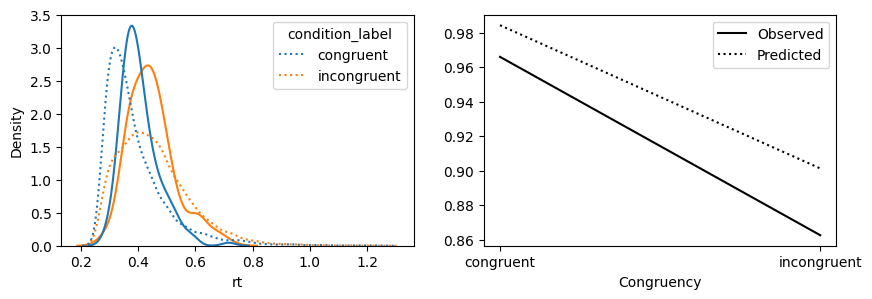

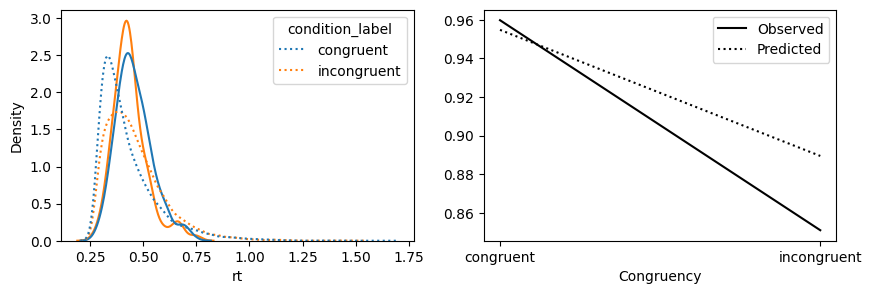

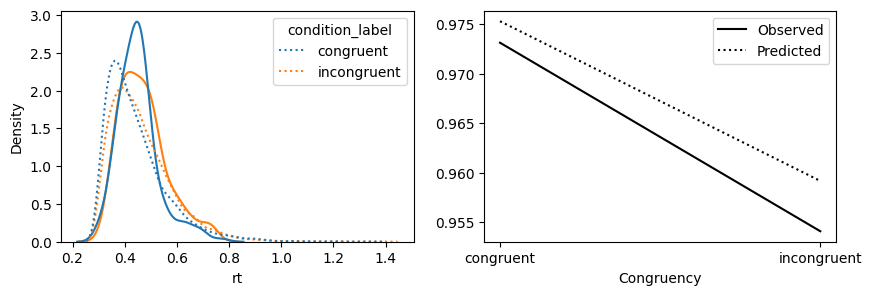

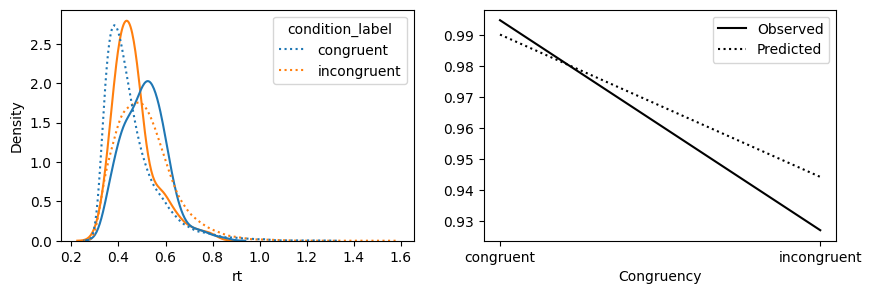

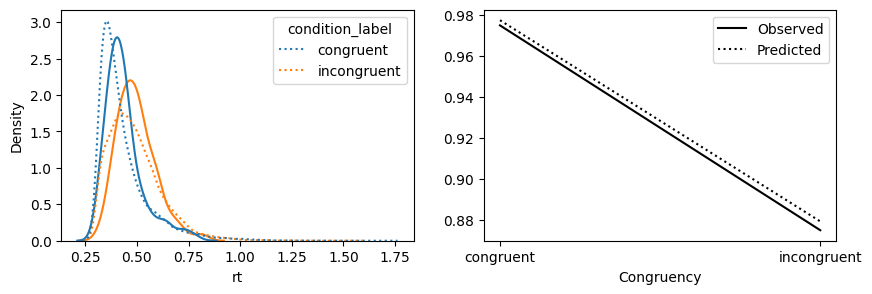

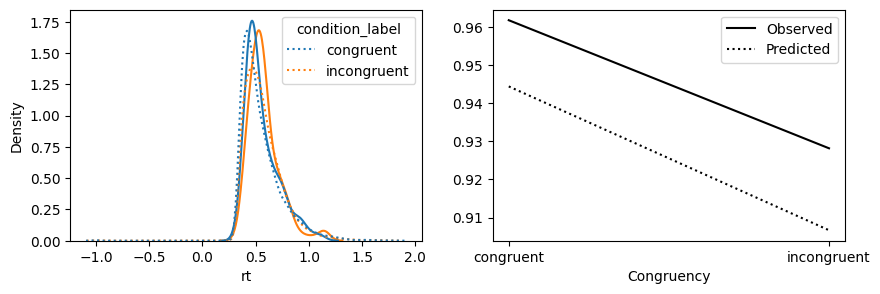

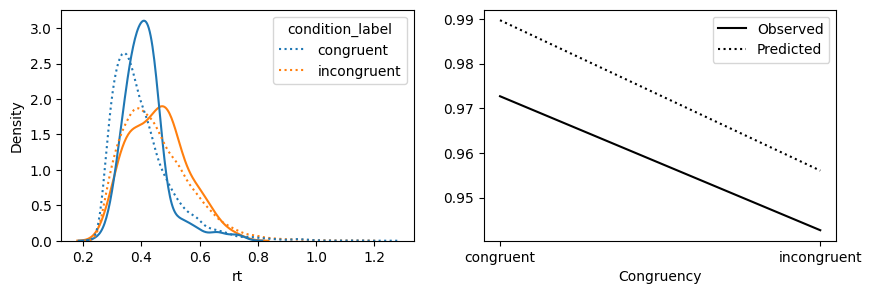

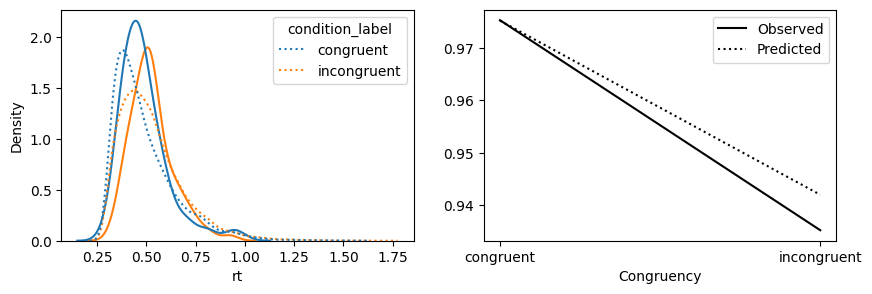

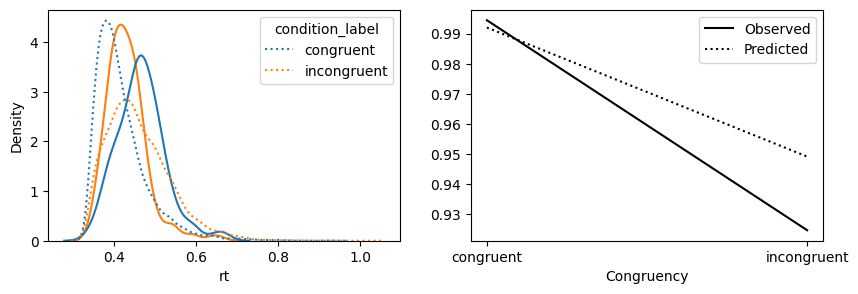

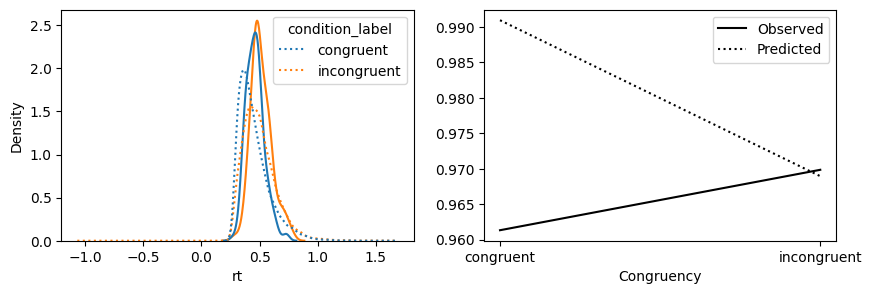

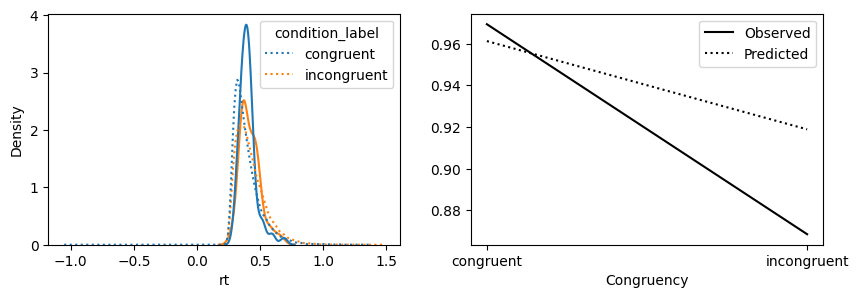

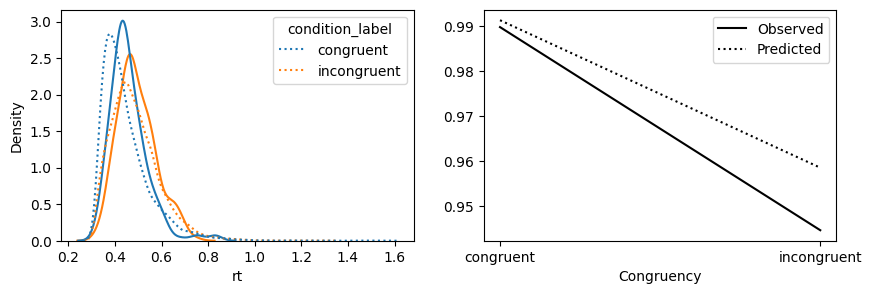

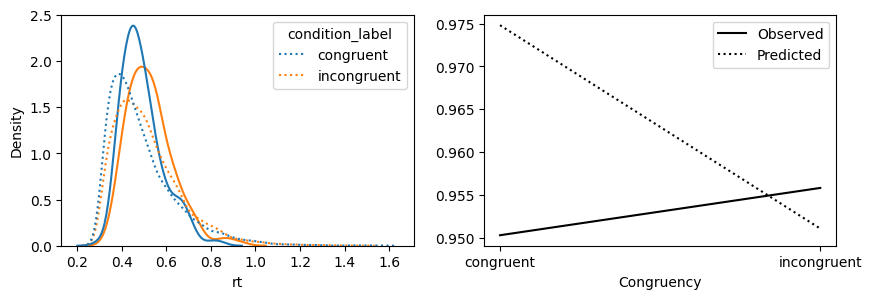

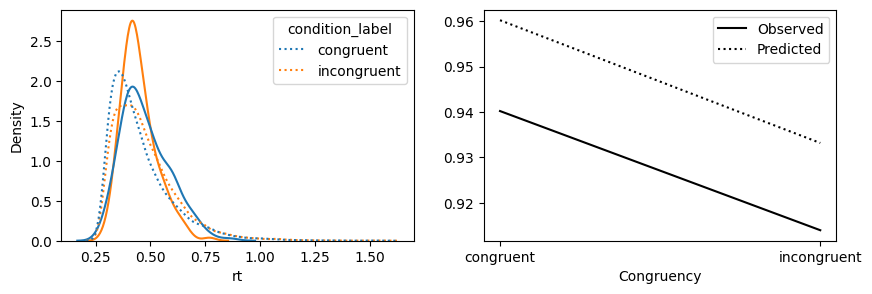

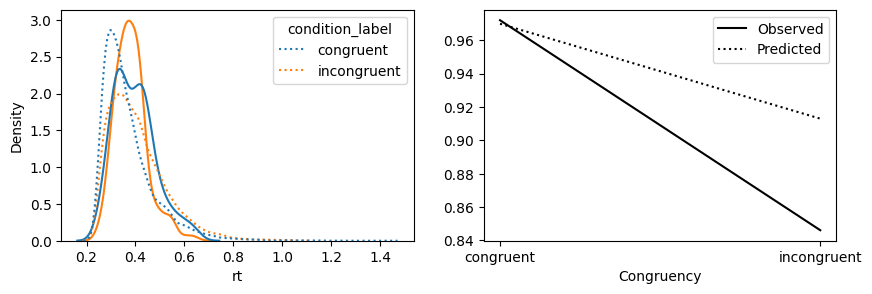

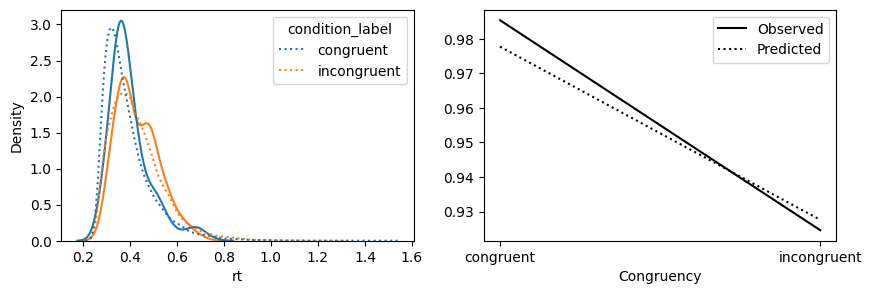

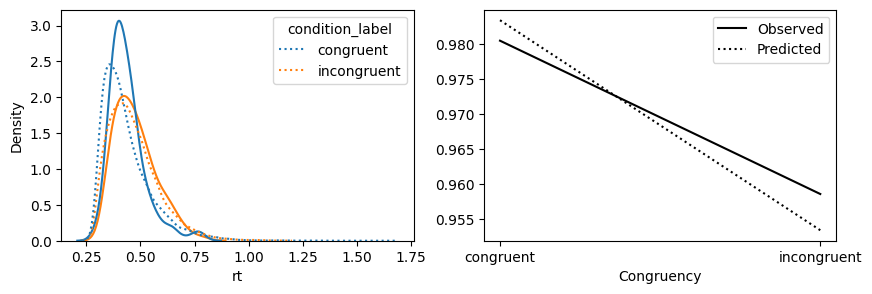

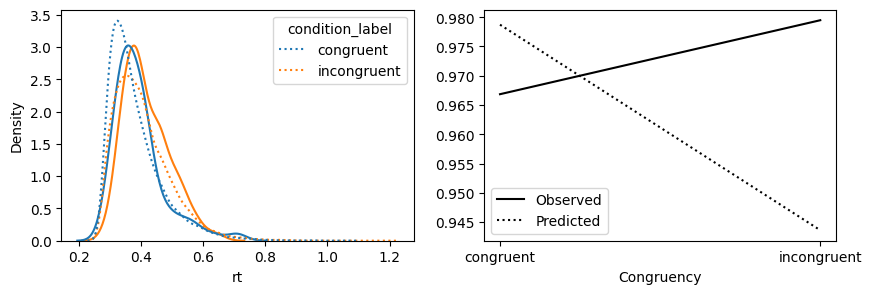

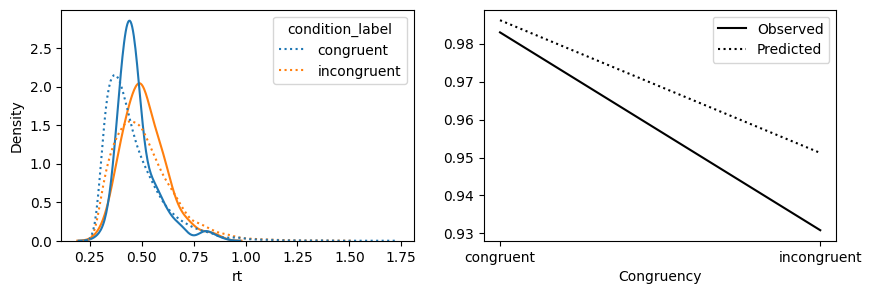

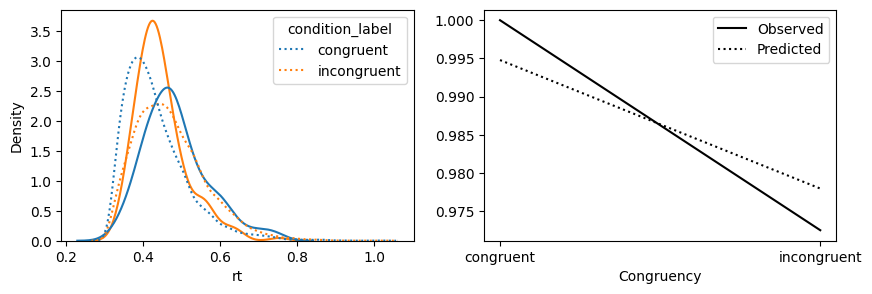

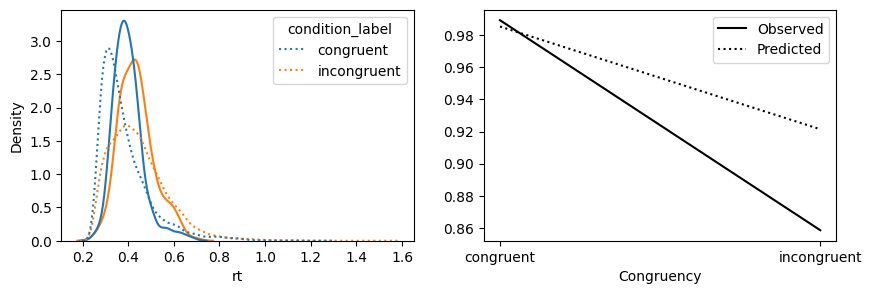

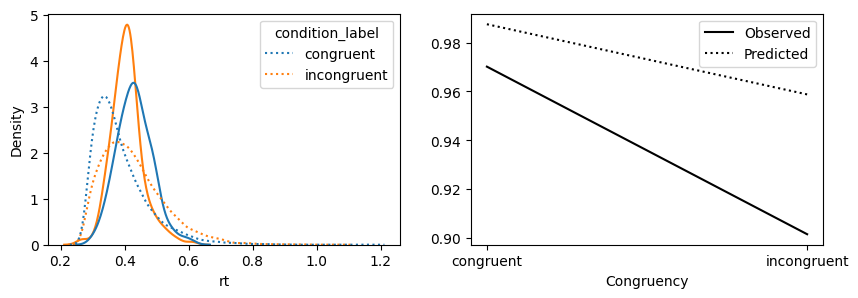

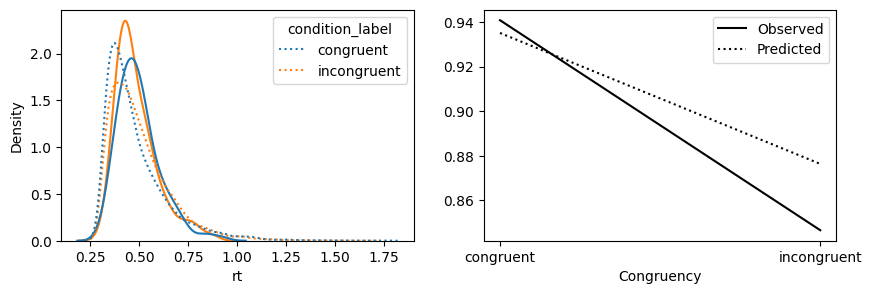

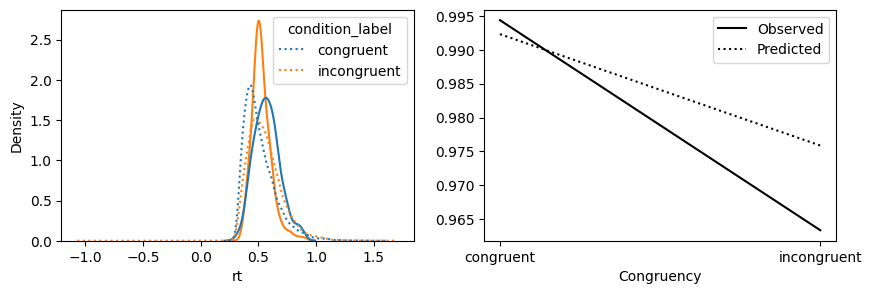

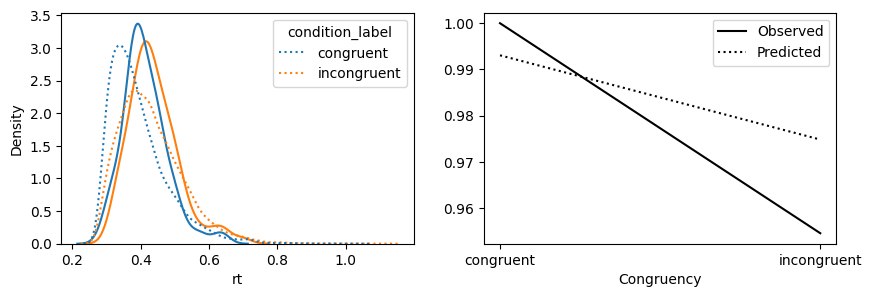

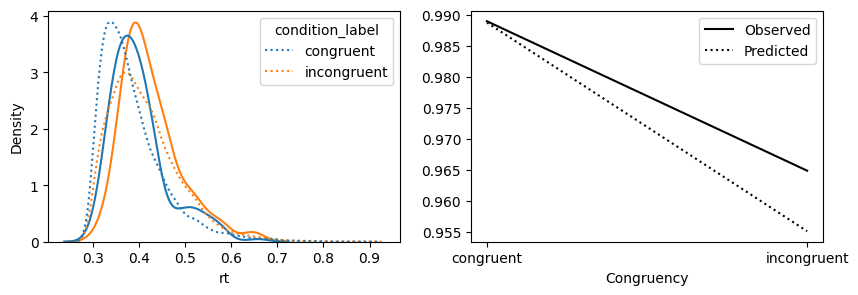

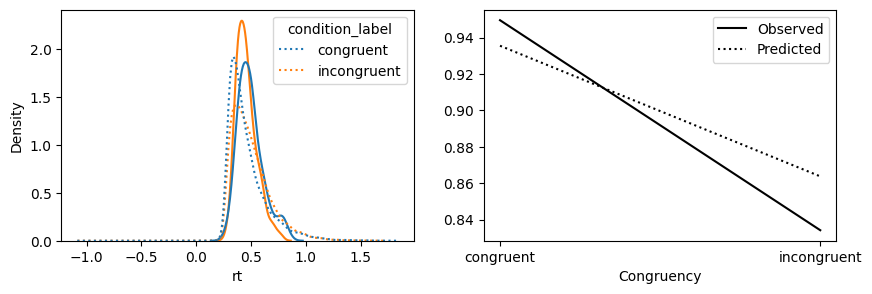

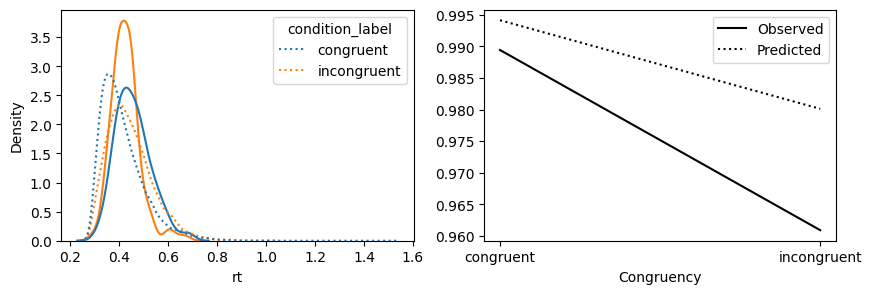

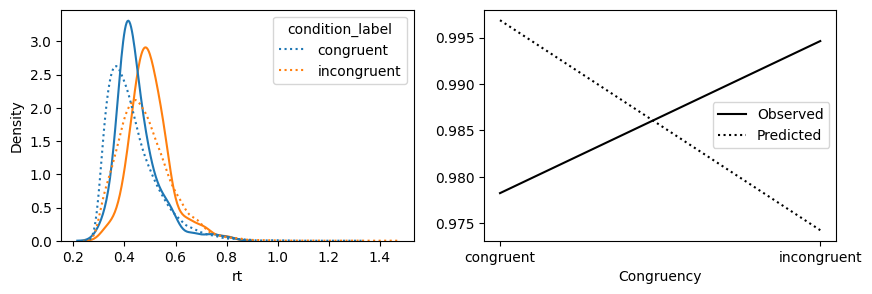

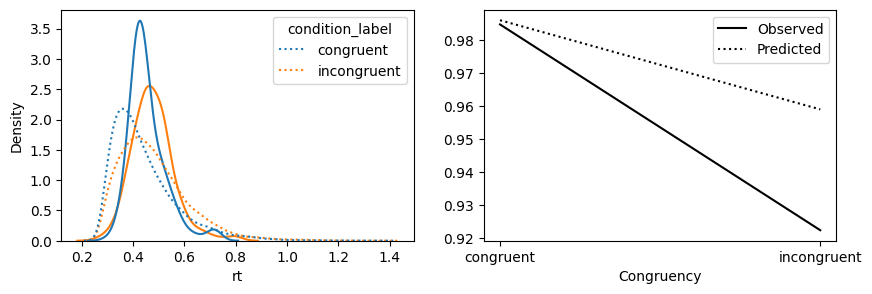

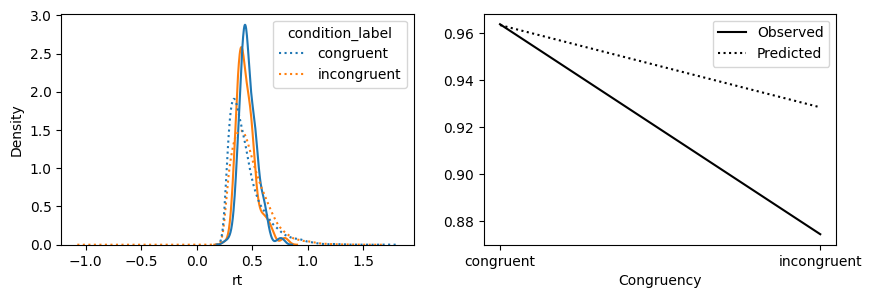

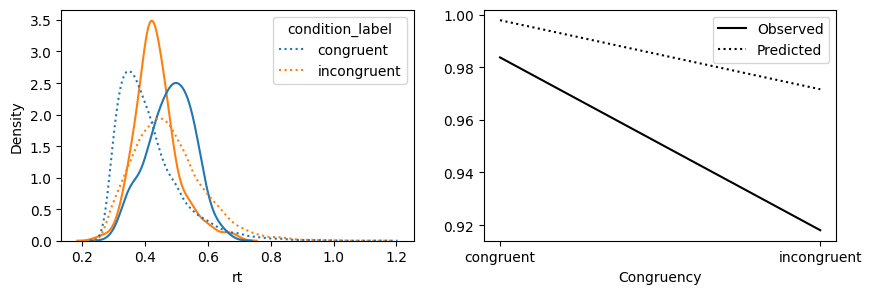

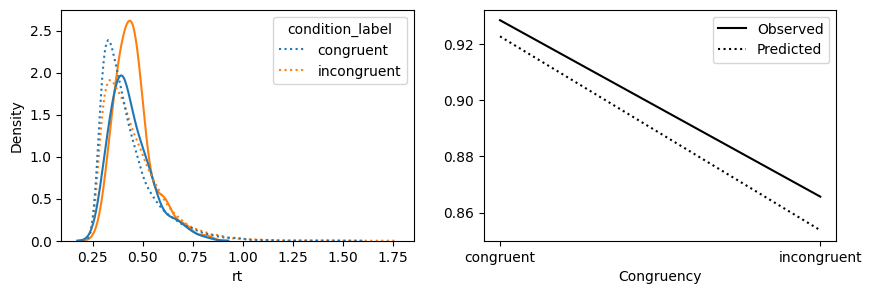

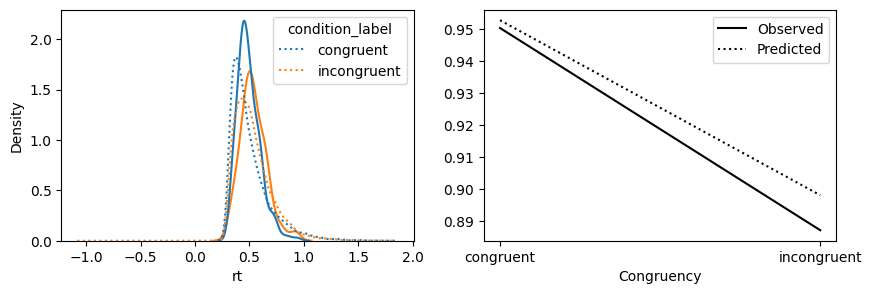

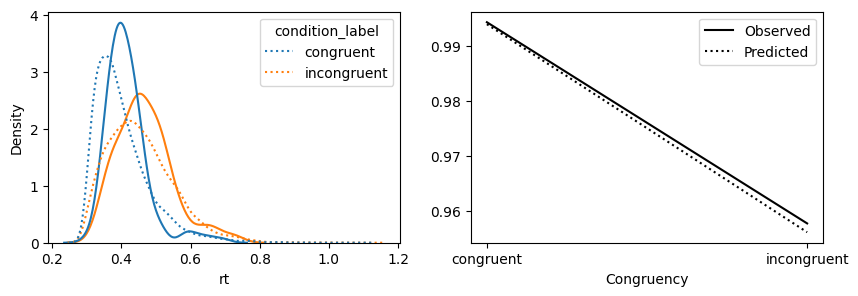

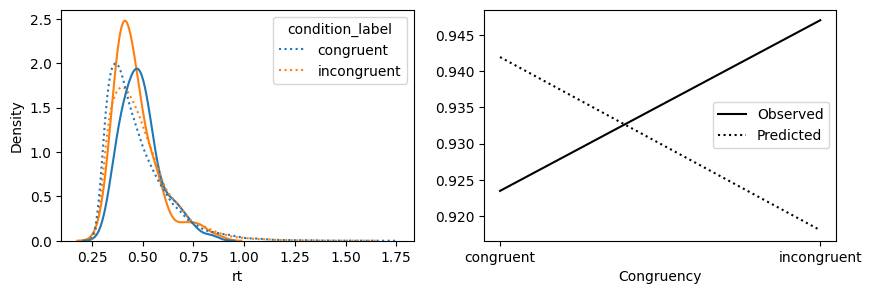

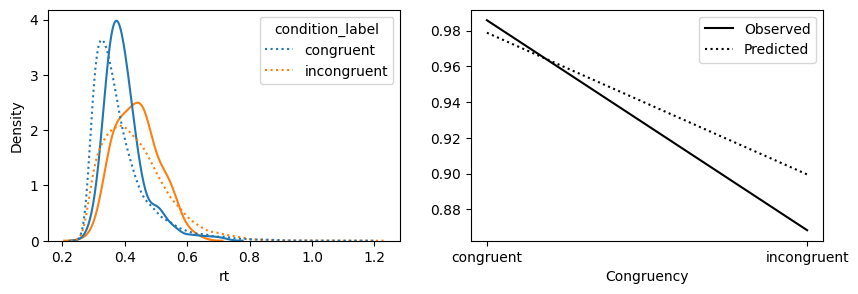

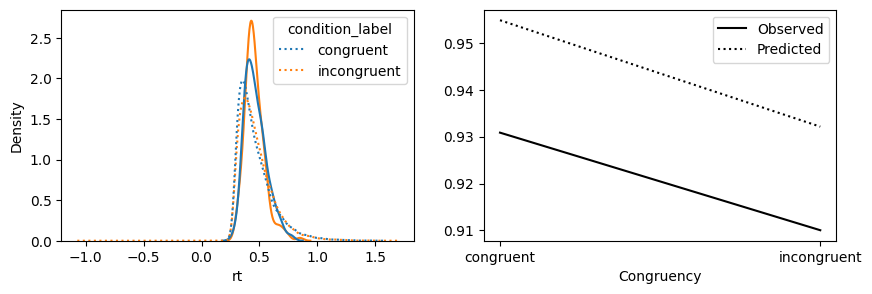

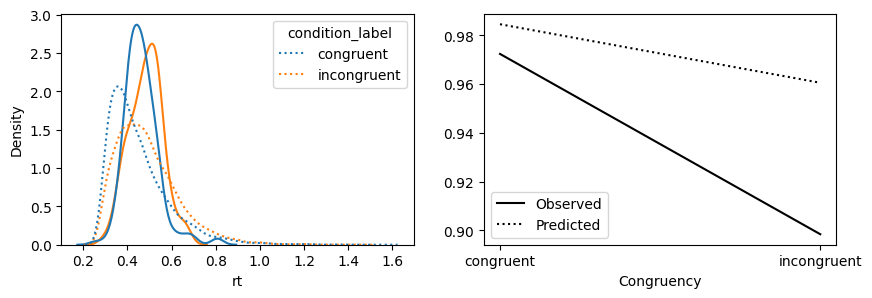

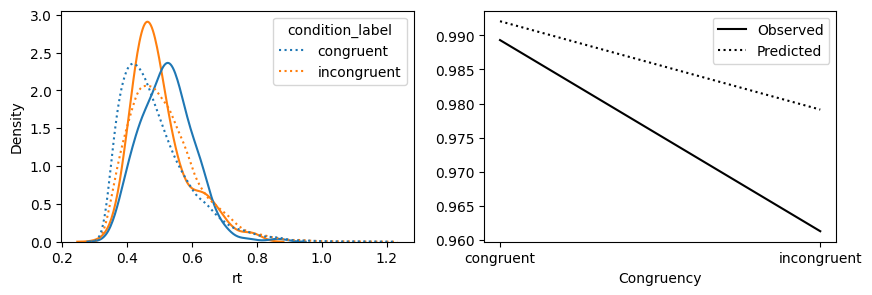

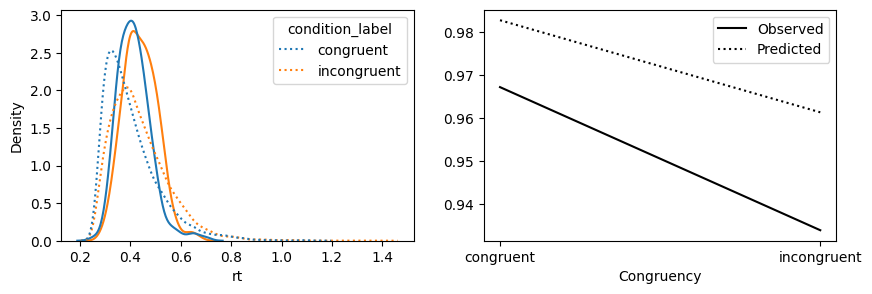

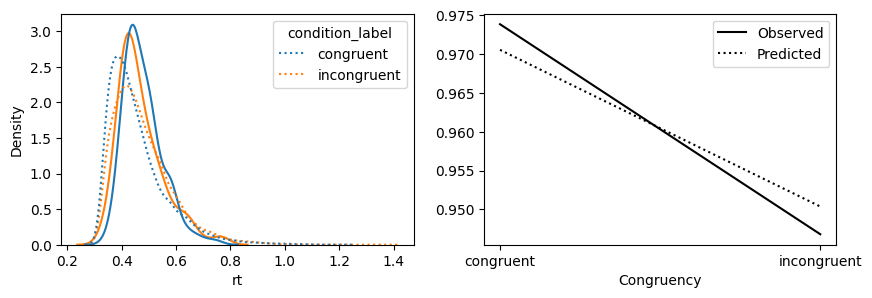

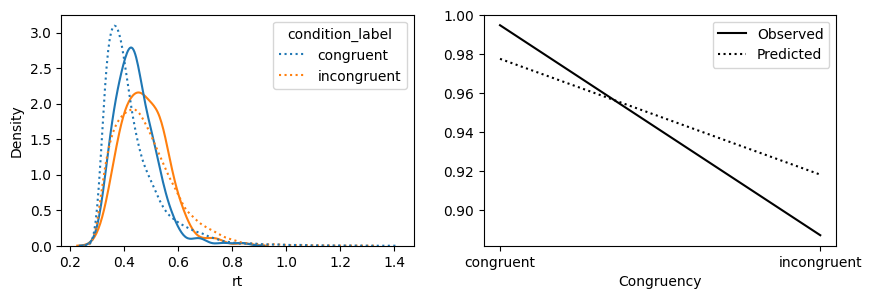

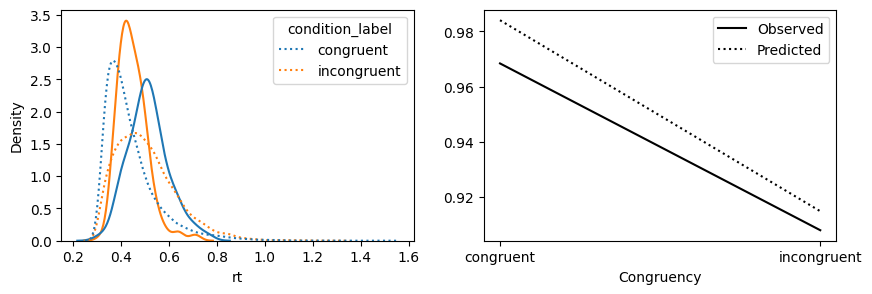

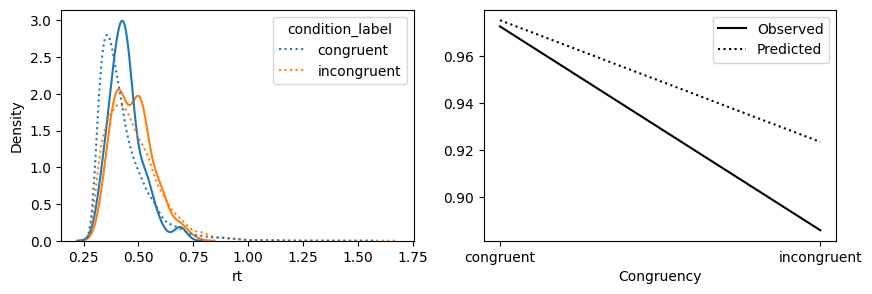

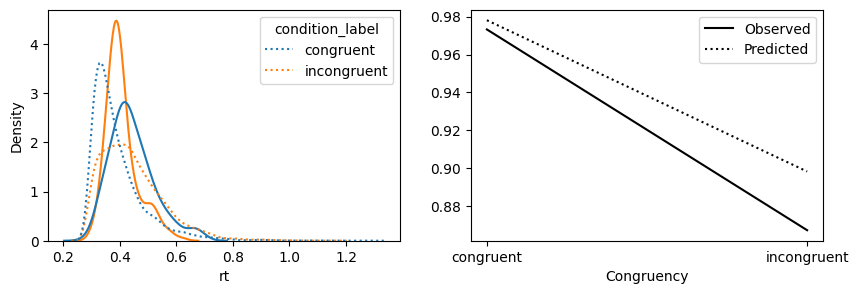

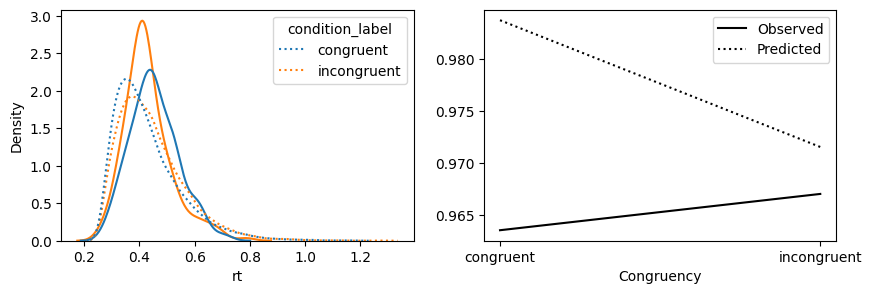

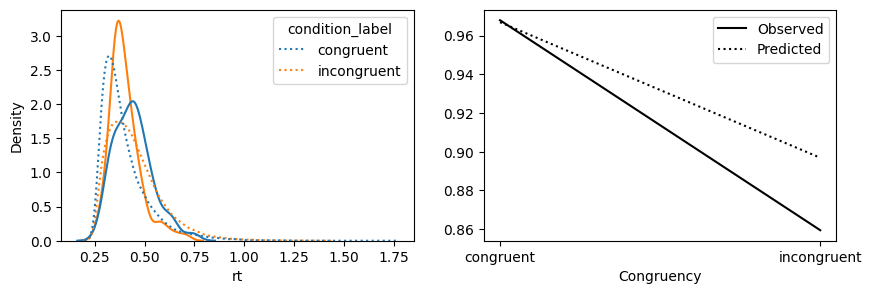

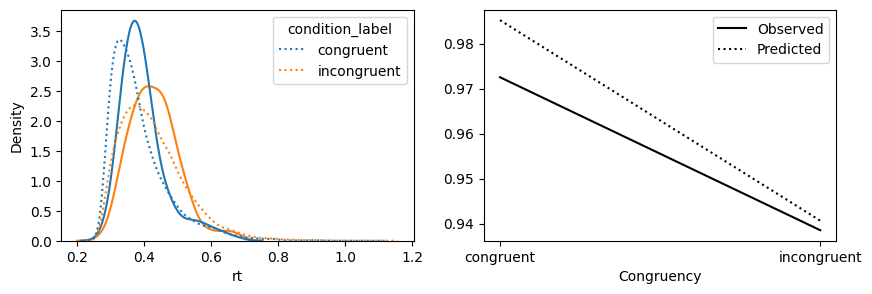

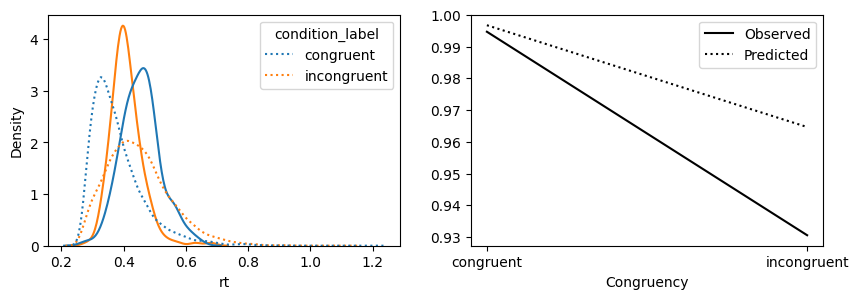

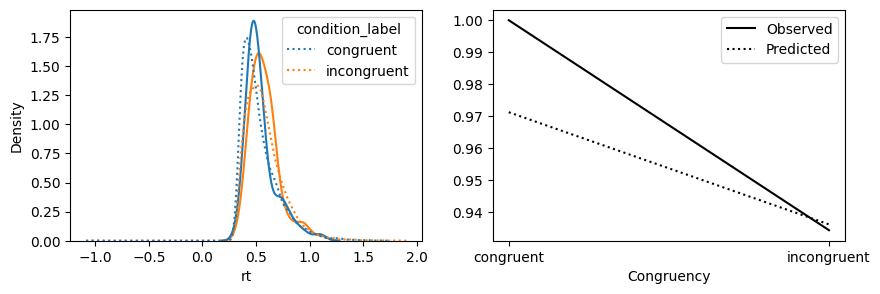

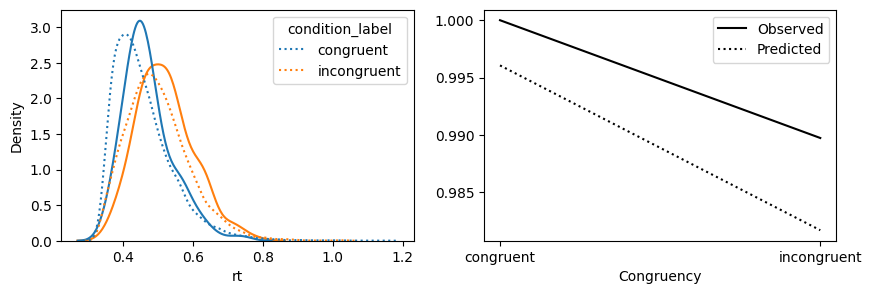

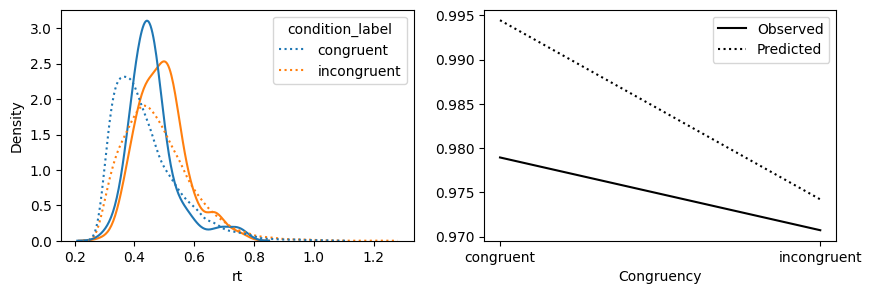

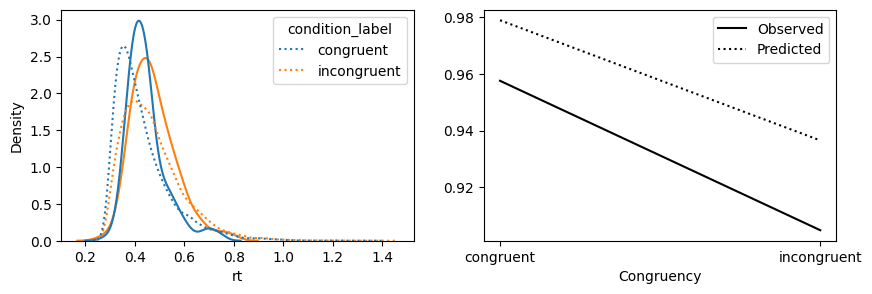

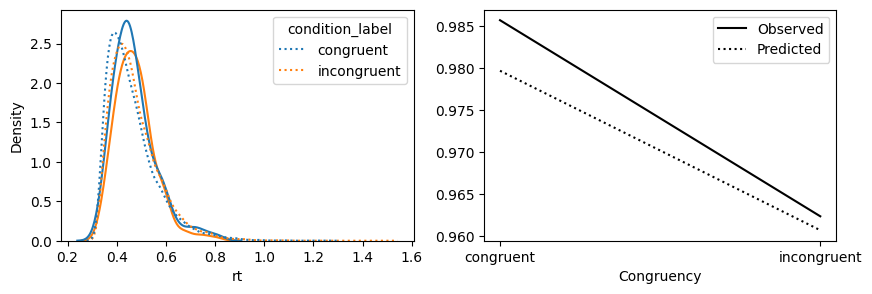

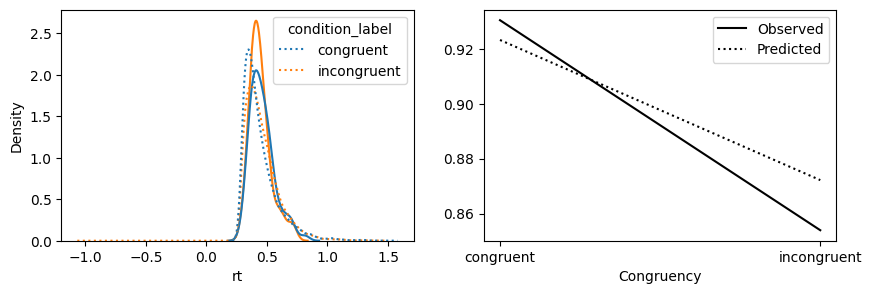

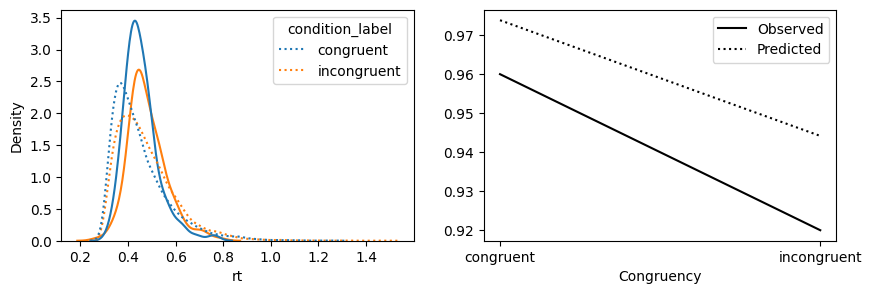

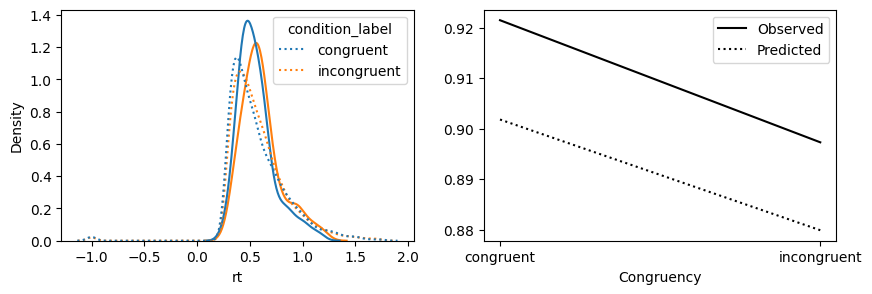

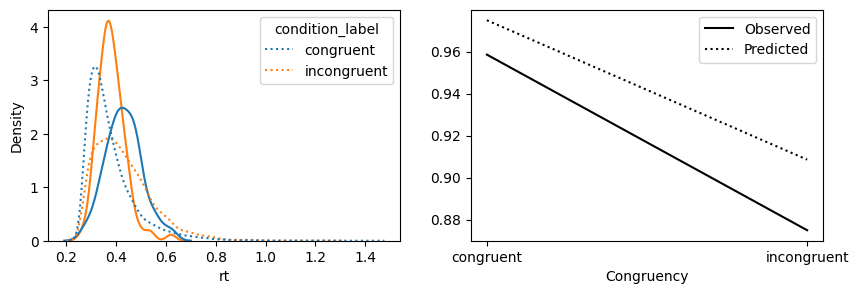

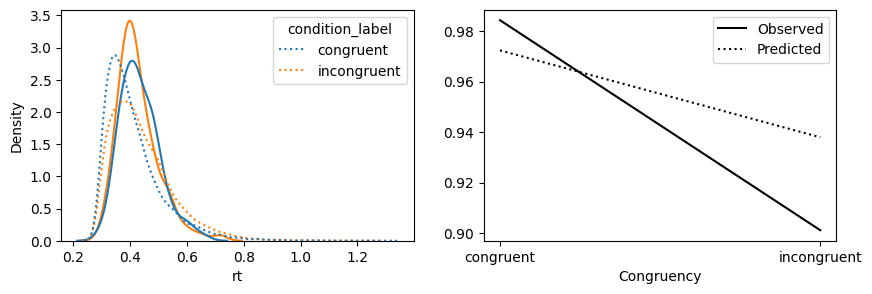

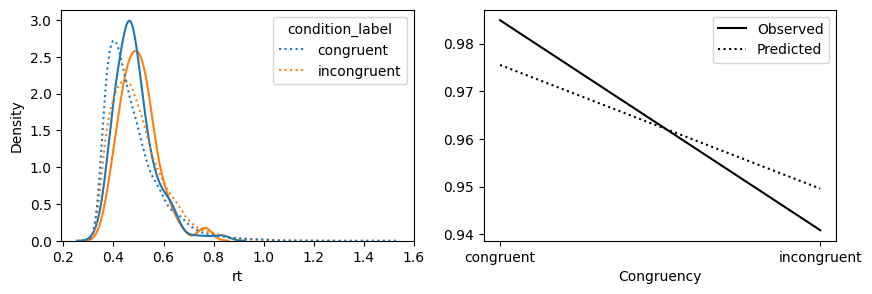

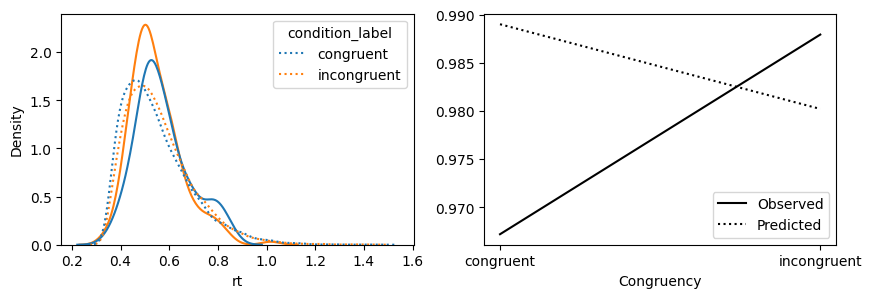

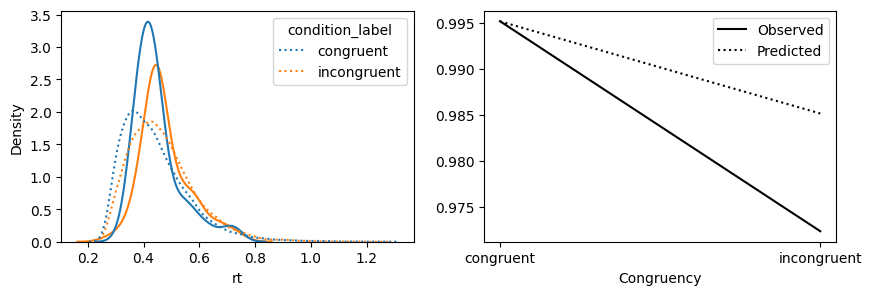

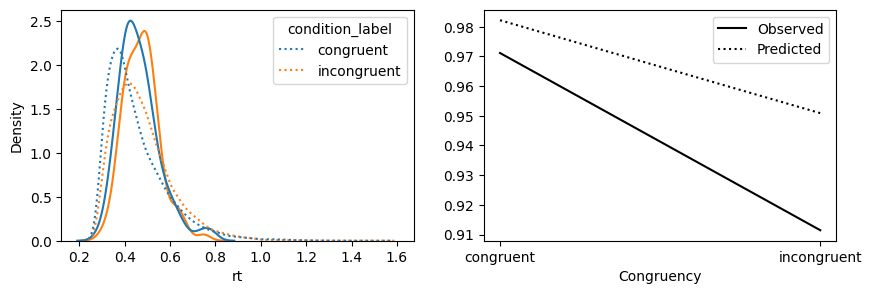

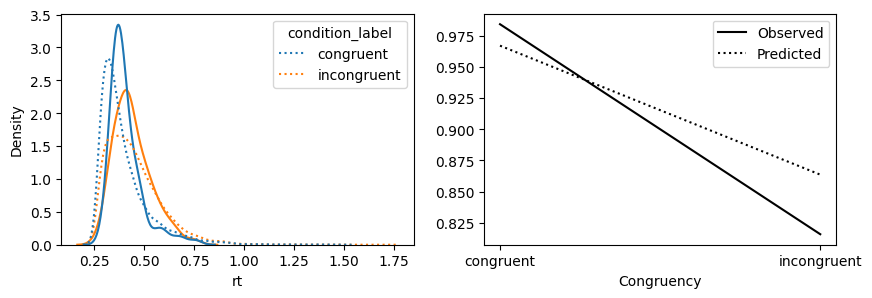

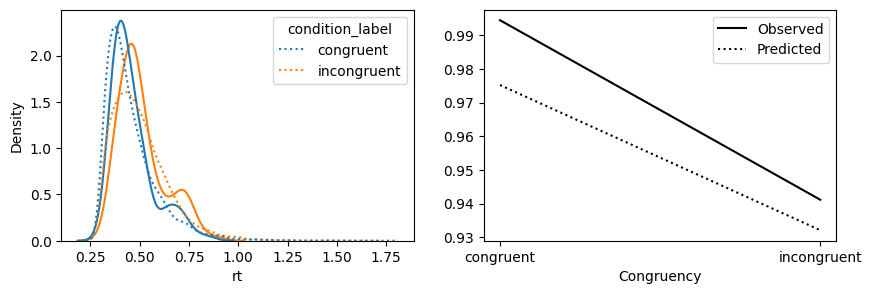

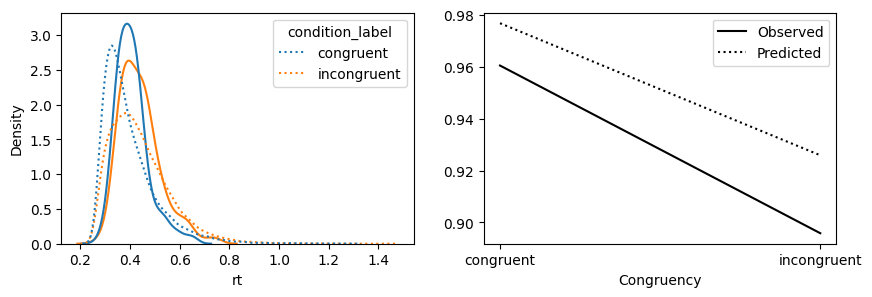

In [47]:

for part in parts:
    
    # filter sample data for given participant and narrow spacing
    part_data_samples = data_complete[data_complete["participant"]==part]

    part_data_samples = part_data_samples[part_data_samples["spacing"] == "narrow"]
    
    # filter empirical data for given participant and narrow spacing
    part_data = empirical_data[empirical_data["participant"] == part]

    part_data = part_data[part_data["spacing_num"] == 1]
    
    part_data["condition_label"] = part_data["congruency_num"].map({0.0: "congruent", 1.0: "incongruent"})
    
    # compute empirical accuracy
    empirical_accuracies_congruent.append(np.mean(part_data[part_data["congruency_num"] == 0]["accuracy"]))
    empirical_accuracies_incongruent.append(np.mean(part_data[part_data["congruency_num"] == 1]["accuracy"]))
    
    
    # resimulate data
    data_resimulated = resim_data(part_data_samples, num_obs = part_data.shape[0])
    data_resimulated["condition_label"] = data_resimulated["conditions"].map({0.0: "congruent", 1.0: "incongruent"})
    
    # compute resimulated data
    resimulated_accuracies_congruent.append(np.mean(data_resimulated[data_resimulated["conditions"] == 0]["accuracy"]))
    resimulated_accuracies_incongruent.append(np.mean(data_resimulated[data_resimulated["conditions"] == 1]["accuracy"]))
    
    # plot individual fit
    fig, axes = plt.subplots(1,2, figsize=(10,3))

    sns.kdeplot(part_data, x="rt", hue="condition_label", ax=axes[0], label = "Observed")

    sns.kdeplot(data_resimulated, x="rt", hue="condition_label", ax=axes[0], linestyle=":", label = "Predicted")

    aggr_data = part_data.groupby("congruency_num").mean("accuracy")

    aggr_data_resim = data_resimulated.groupby("condition_label").mean("accuracy")

    aggr_data.reset_index(inplace=True)

    aggr_data_resim.reset_index(inplace=True) 
    
    # aggr_data_resim["condition_label"] = aggr_data_resim["conditions"].map({0.0: "congruent", 1.0: "incongruent"})

    axes[1].plot(aggr_data["congruency_num"], aggr_data["accuracy"], "-", color="black", label="Observed")

    axes[1].plot(aggr_data_resim["condition_label"], aggr_data_resim["accuracy"], ":",  color="black", label="Predicted")

    axes[1].set_xlabel("Congruency")
    
    axes[1].legend()


<Axes: ylabel='Count'>

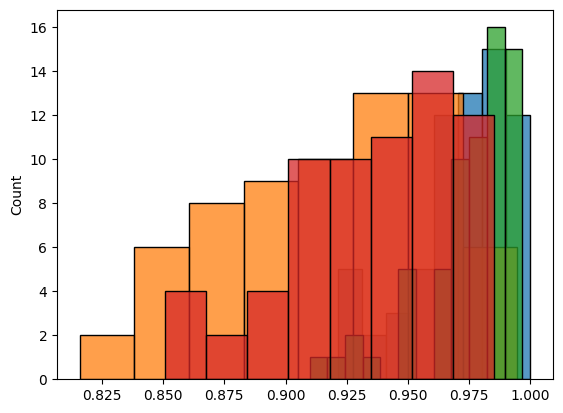

In [31]:
sns.histplot(empirical_accuracies_congruent, label="Empirical Congruent")
sns.histplot(empirical_accuracies_incongruent, label="Empirical Incongruent")
sns.histplot(resimulated_accuracies_congruent, label="Resimulated Congruent")
sns.histplot(resimulated_accuracies_incongruent, label="Resimulated Incongruent")

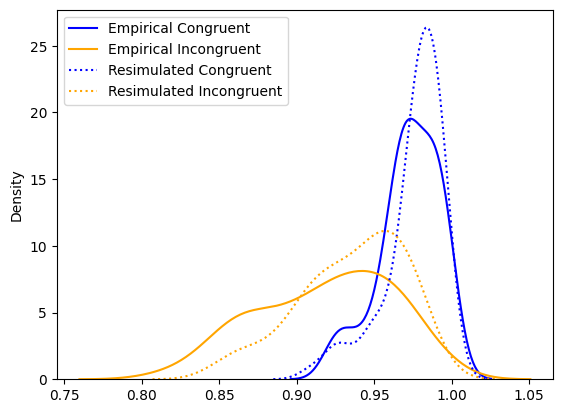

In [37]:
sns.kdeplot(empirical_accuracies_congruent, label="Empirical Congruent", color="blue")
sns.kdeplot(empirical_accuracies_incongruent, label="Empirical Incongruent", color="orange")
sns.kdeplot(resimulated_accuracies_congruent, linestyle=":", label="Resimulated Congruent", color="blue")
sns.kdeplot(resimulated_accuracies_incongruent, linestyle=":", label="Resimulated Incongruent", color="orange")
plt.legend()

In [17]:
data_resimulated

rt  accuracy  conditions  num_obs  num_resim  partricipant
0    0.425380       1.0           0      369          0           985
1    0.583380       1.0           0      369          0           985
2    0.433380       1.0           0      369          0           985
3    0.323380       1.0           0      369          0           985
4    0.348380       1.0           0      369          0           985
..        ...       ...         ...      ...        ...           ...
364  0.538307       1.0           1      369         49           985
365  0.366307       1.0           1      369         49           985
366  0.291307       1.0           1      369         49           985
367  0.301307       0.0           1      369         49           985
368  0.365307       1.0           1      369         49           985

[18450 rows x 6 columns]